### Supervised learning - Modeling whether or not people will place a term deposit
#### Author: Stefan Ilić
#### Data set source: UCI Machine Learning Repository
#### Data set link: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

#### Assumptions:
###### Currnet date: Wednesday, December 1st, 2010
###### Data collected from May 2008 to November 2010

In [1]:
# Script run time on local machine around 10 min

In [1]:
# Technical environment setup and preparation

#The analysis was done with Pyhton == 3.8.10
#!pip instal numpy == 1.21.6
#!pip install pandas == 1.3.5
#!pip install matplotlib == 3.2.2
#!pip install seaborn == 0.11.2
#!pip install sklearn == 1.0.2
#!pip install category-encoders == 2.4.1
#!pip install feature-engine == 1.5.1

In [2]:
# Liaberies import
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import xgboost as xgb
from datetime import datetime as dt
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

# Column transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder as no_order_encoder
from category_encoders.ordinal import OrdinalEncoder as order_encoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# Data splitting
from sklearn.model_selection import train_test_split

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model enhancement
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# Column Transformer and Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

# Data viewing
from sklearn import set_config
from sklearn.tree import plot_tree
sns.set_palette("Set2")

# Random state
seed = 13

# Notebook setup
warnings.filterwarnings('ignore')

## Import and simple description of the data

In [3]:
data = pd.read_csv("bank_data.csv", sep = ";")
df = pd.DataFrame(data)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
new_col_name = {"age": "clients_age"
              , "job": "clients_job"
              , "marital": "clients_marital_status"
              , "education": "clients_education"
              , "default": "yn_loan_default"
              , "housing": "yn_house_loan"
              , "loan": "yn_pers_loan"
              , "contact": "contact_channel"
              , "month": "month_of_last_contact"
              , "day_of_week": "weekday_of_last_contact"
              , "duration": "duration_of_last_contact"
              , "campaign": "curr_camp_num_calls"
              , "pdays": "num_days_since_last_contact"
              , "previous": "prev_camp_num_calls"
              , "poutcome": "prev_camp_outcome"
              , "emp.var.rate": "employment_var_rate"
              , "cons.price.idx": "cpi"
              , "cons.conf.idx": "cci"
              , "nr.employed": "num_of_employees"
                      }
df.rename(columns = new_col_name, inplace = True)
df.head(2)

,clients_age,clients_job,clients_marital_status,clients_education,yn_loan_default,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,...,curr_camp_num_calls,num_days_since_last_contact,prev_camp_num_calls,prev_camp_outcome,employment_var_rate,cpi,cci,euribor3m,num_of_employees,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


With the dataset came a column definition document. Given the number of columns it makes sense to have this description callable. Hence, I put it into a dictionary.

In [5]:
feature_desc = {"clients_age": "age (num)"
              , "clients_job": "type of job (cat)"
              , "clients_marital_status": "marital status (cat)"
              , "clients_education": "educational level (cat)"
              , "yn_loan_default": "has credit in default (cat)"
              , "yn_house_loan": "has housing loan (cat)"
              , "yn_pers_loan": "has personal loan (cat)"
              , "contact_channel": "contact communication type (cat)"
              , "month_of_last_contact": "last contact month of year (cat)"
              , "weekday_of_last_contact": "last contact day of week (cat)"
              , "duration_of_last_contact": "last contact duration in seconds (num)"
              , "curr_camp_num_calls": "number of contacts performed during this campaign and for this client (num)"
              , "num_days_since_last_contact": "number of days that passed by after the client was last contacted from previous campaign, 999 not contacted before (num)"
              , "prev_camp_num_calls": "number of contacts pefromed before this campaign and for this client (num)"
              , "prev_camp_outcome": "outcome of the previous marketing campaign (cat)"
              , "employment_var_rate": "employment variation rate - quarterly indicator (num)"
              , "cpi": "consumer price index - monthly indicator (num)"
              , "cci": "consumer confidence index - monthly indicator (num)"
              , "euribor3m": "euribor 3-month rate - daily indicator (num)"
              , "num_of_employees": "number of employees - quarterly indicator (num)"
              , "y": "has the client subscirbed to a term deposit? (cat)"
                      }

Let's get the basic understanding of the data

In [6]:
df.shape

(41188, 21)

In [7]:
df.describe()

,clients_age,duration_of_last_contact,curr_camp_num_calls,num_days_since_last_contact,prev_camp_num_calls,employment_var_rate,cpi,cci,euribor3m,num_of_employees
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### Some initial conclusions for numerical features are (disregarding "duration_of_last_contact"):
- Youngest client has 17 years and the oldest 98. As median (38) is smaller than the mean (40) it points to right-skewed data.
- There is quite high maximum of calls - 56. Were people called more than 50 times during the campaign? Do these refer just to campaign or total number of call for all client's transactions?
- Most clients were not contacted before (999)
- Number of call during previous campaign seems logical. If same approach for call counting was used it could mean that there was an input error for "curr_camp_num_calls"...
- Economic indicators indicate turbulent times - highly volatile "employment_var_rate" and "euribor3m" while "cci" indicates that consumer sentiment is pessimistic.

In [8]:
df.describe(include = 'object')

,clients_job,clients_marital_status,clients_education,yn_loan_default,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,prev_camp_outcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [9]:
cat_scope = list(df.describe(include = ["object"]).columns)
for feature in cat_scope:
    most_common = df[feature].describe().loc["top"]
    cnt = df[feature].describe().loc["freq"]
    total = df[feature].describe().loc["count"]
    rate = cnt/total
    print(f"The most frequent category of feaure \033[1m\"{feature}\"\033[0m is \033[43m\"{most_common.upper()}\"\033[49m with participation rate of \033[47m{rate*100:.2f}%\033[49m \n")

The most frequent category of feaure "clients_job" is "ADMIN." with participation rate of 25.30% 

The most frequent category of feaure "clients_marital_status" is "MARRIED" with participation rate of 60.52% 

The most frequent category of feaure "clients_education" is "UNIVERSITY.DEGREE" with participation rate of 29.54% 

The most frequent category of feaure "yn_loan_default" is "NO" with participation rate of 79.12% 

The most frequent category of feaure "yn_house_loan" is "YES" with participation rate of 52.38% 

The most frequent category of feaure "yn_pers_loan" is "NO" with participation rate of 82.43% 

The most frequent category of feaure "contact_channel" is "CELLULAR" with participation rate of 63.47% 

The most frequent category of feaure "month_of_last_contact" is "MAY" with participation rate of 33.43% 

The most frequent category of feaure "weekday_of_last_contact" is "THU" with participation rate of 20.94% 

The most frequent category of feaure "prev_camp_outcome" is "N

#### Some initial conclusions for categorical features are:
- Administration workers are the most dominant job type.
- Most clients are married.
- Nearly 30% of contacted clients have a university degree.
- Most clients have a mortgage loan but not a consumer one and are not in default.
- Clients prefer to be contacted over the mobile phone.
- May is the most active month for the call center while no concentration can be seen for any particular weekday.
- Only 11.27% of contacted clients agreed to the offered product. This indicates high inbalance in the data.

## Defining true temporal dataset features

The data does not contain a date column but the data engineering team says that it is ordered in chronological order.
Luckily, the column "euribor3m" is a daily indicator and can serve as an way to distinguish between dates. This should be coupled with "day_of_week" feature in case the value of 3m euribor is same for consecutive days. Similar should be done for month, quarter, and year.

In [10]:
# defining day of campaign
d=1
d_l = ["euribor3m", "weekday_of_last_contact", "campaign_day"]
for i in range(1, len(df)):
        if i == len(df)-1:
            df.loc[i, d_l[2]] = d
        elif i == 1:
            df.loc[0, d_l[2]] = d
            df.loc[1, d_l[2]] = d
        elif (df.loc[i, d_l[0]] == df.loc[i-1, d_l[0]]) & (df.loc[i, d_l[1]] == df.loc[i-1, d_l[1]]):
            df.loc[i, d_l[2]] = d
        else:
            d += 1
            df.loc[i, d_l[2]] = d
df[d_l[2]] = df[d_l[2]].astype(int)

# defining month of campaign
m=1
m_l = ["cpi", "month_of_last_contact", "campaign_month"]
for i in range(1,len(df)):
        if i == len(df)-1:
            df.loc[i, m_l[2]] = m
        elif i == 1:
            df.loc[0, m_l[2]] = m
            df.loc[1, m_l[2]] = m
        elif (df.loc[i, m_l[0]] == df.loc[i-1, m_l[0]]) & (df.loc[i, m_l[1]] == df.loc[i-1, m_l[1]]):
            df.loc[i, m_l[2]] = m
        else:
            m+=1
            df.loc[i, m_l[2]] = m
df["campaign_month"] = df["campaign_month"].astype(int)

# defining quarter of campaign
q=1
q_l = ["month_of_last_contact", "campaign_month", "campaign_quarter"]
for i in range(1,len(df)):
        if i == len(df)-1:
            df.loc[i, q_l[2]] = q
        elif i == 1:
            df.loc[0, q_l[2]] = q
            df.loc[1, q_l[2]] = q
        elif df.loc[i, q_l[0]] in ["feb","mar","may","jun","aug","sep","nov","dec"]:
            df.loc[i, q_l[2]] = q
        elif (df.loc[i, q_l[0]] in ["jan", "apr","jul","oct"]) & (df.loc[i, q_l[1]] == df.loc[i-1, q_l[1]]):
            df.loc[i, q_l[2]] = q
        else:    
            q += 1
            df.loc[i, q_l[2]] = q
df[q_l[2]] = df[q_l[2]].astype(int)

# defining year of campaign
y = 2008
y_l = ["month_of_last_contact", "campaign_year"]
for i in range(1,len(df)):
    if i == 1:
        df.loc[0, y_l[1]] = y
        df.loc[1, y_l[1]] = y
    elif (df.loc[i, y_l[0]] in ["jan","feb","mar"]) & (df.loc[i-1, y_l[0]] in ["oct","nov","dec"]):
        y += 1
        df.loc[i, y_l[1]] = y
    else:
        df.loc[i, y_l[1]] = y
df[y_l[1]] = df[y_l[1]].astype(int)

In [11]:
df.tail()

,clients_age,clients_job,clients_marital_status,clients_education,yn_loan_default,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,...,employment_var_rate,cpi,cci,euribor3m,num_of_employees,y,campaign_day,campaign_month,campaign_quarter,campaign_year
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,yes,490,26,9,2010
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,no,490,26,9,2010
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,no,490,26,9,2010
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,yes,490,26,9,2010
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,no,490,26,9,2010


In [12]:
df["euribor3m"].nunique()

316

#### Conclusion
The new column "campaign_day" tells us that this campagin was 490 working days long. The number 490 is bigger than what returns nunique() function when applied to "euribor3m" column. This indicates that 3m euribor was the same for more than one day. This proves that it was not too cautious to combine two features.

Additional informatin is that the campaing was conducted in 26 separate months over 9 quarters and it is confirmed that it lasted from May 2008 till November 2010.

## Dealing with mixed data types in the same column

Feature "pdays" has the following definition "number of days that passed by after the client was last contacted from previous campaign, 999 not contacted before (num)". Based on the definition 999 is actually a category and not number of days since last contact.

In [13]:
fltr_999 = df["num_days_since_last_contact"] == 999
cnt_999 = len(df.loc[fltr_999])
total_cnt = len(df)
print(f"The participatio of value 999 in column \"num_days_since_last_contact\" is {cnt_999/total_cnt*100:.2f}%")

The participatio of value 999 in column "num_days_since_last_contact" is 96.32%


Given that it cannot be made into a valid numberical value and how dominant value 999 is in the data (96.32%) it makes sense to  discretize the remaining values.

True moment of last contact can be estimated by using previously constracted column "campaign_day".

In [14]:
# Determine how long ago (from the end of the campaign) was the previous contact made

total_days = df["campaign_day"].max()
df["true_num_days_since_last_contact"] = np.where(df["num_days_since_last_contact"]==999
                                                 ,999
                                                 ,total_days - df["campaign_day"] + df["num_days_since_last_contact"]
                                                 )

# Checking success of transformation
fltr = df["num_days_since_last_contact"] != 999
df.loc[fltr, ["num_days_since_last_contact", "campaign_day", "true_num_days_since_last_contact"]].head()

,num_days_since_last_contact,campaign_day,true_num_days_since_last_contact
24108,6,99,397
24264,4,102,392
24279,4,102,392
24397,3,102,391
24482,4,102,392


In [15]:
# Discretizing "true_num_days_since_last_contact"

bins = [-1, 23, 130, 998, 1000]
categories = ["contacted 1 month ago", "contacted 6 months ago", "contacted long ago", "not contacted before"]

true_num_days_since_last_contact_cat = pd.cut(df["true_num_days_since_last_contact"]
                                            , bins = bins
                                            , labels=categories
                                            , include_lowest = True
                                             )
true_num_days_since_last_contact_cat

0        not contacted before
1        not contacted before
2        not contacted before
3        not contacted before
4        not contacted before
                 ...         
41183    not contacted before
41184    not contacted before
41185    not contacted before
41186    not contacted before
41187    not contacted before
Name: true_num_days_since_last_contact, Length: 41188, dtype: category
Categories (4, object): ['contacted 1 month ago' < 'contacted 6 months ago' < 'contacted long ago' < 'not contacted before']

In [16]:
df["true_num_days_since_last_contact_cat"] = true_num_days_since_last_contact_cat
df.head()

,clients_age,clients_job,clients_marital_status,clients_education,yn_loan_default,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,...,cci,euribor3m,num_of_employees,y,campaign_day,campaign_month,campaign_quarter,campaign_year,true_num_days_since_last_contact,true_num_days_since_last_contact_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,-36.4,4.857,5191.0,no,1,1,1,2008,999,not contacted before
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,-36.4,4.857,5191.0,no,1,1,1,2008,999,not contacted before
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,-36.4,4.857,5191.0,no,1,1,1,2008,999,not contacted before
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,-36.4,4.857,5191.0,no,1,1,1,2008,999,not contacted before
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,-36.4,4.857,5191.0,no,1,1,1,2008,999,not contacted before


## Dealing with duplicates

In [17]:
full_dupl_idx = list(df[df.duplicated(keep = False)].index)
full_dupl_idx.sort()

df.loc[full_dupl_idx, ["clients_age", "clients_job", "clients_marital_status", "duration_of_last_contact", "campaign_day"]]

,clients_age,clients_job,clients_marital_status,duration_of_last_contact,campaign_day
1265,39,blue-collar,married,124,4
1266,39,blue-collar,married,124,4
12260,36,retired,married,88,41
12261,36,retired,married,88,41
14155,27,technician,single,331,48
14234,27,technician,single,331,48
16819,47,technician,divorced,43,56
16956,47,technician,divorced,43,56
18464,32,technician,single,128,61
18465,32,technician,single,128,61


### Conclusion
It is highly unlikely that on the same day an equally long telephone call with two people that share age, occupation, marital status and other observed characteristics can happen. Because of this, I judge that these records are trully duplicates and they should be removed.

In [18]:
df.drop_duplicates(keep = "first", inplace=True)
df.shape

(41176, 27)

In [19]:
X = df.drop(labels = "y", axis = 1)
y = df["y"]

X_train_prep, X_test_prep, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = seed,
                                                    stratify=y
                                                   )

In [20]:
# Training data
print('Training data - independent feature: ', X_train_prep.shape)
print('Training data - a target feature: ', y_train.shape)

# Holdout data (often called also test data)
print('Training data - independent feature: ', X_test_prep.shape)
print('Training data - a target feature: ', y_test.shape)

Training data - independent feature:  (28823, 26)
Training data - a target feature:  (28823,)
Training data - independent feature:  (12353, 26)
Training data - a target feature:  (12353,)


In [21]:
# Transforming the target variable to numberical feature
y_train = y_train.apply(lambda x: 0 if x == "no" else 1)
y_test = y_test.apply(lambda x: 0 if x == "no" else 1)

## Investigating missing values

In [22]:
print(X_train_prep.isna().sum())

clients_age                             0
clients_job                             0
clients_marital_status                  0
clients_education                       0
yn_loan_default                         0
yn_house_loan                           0
yn_pers_loan                            0
contact_channel                         0
month_of_last_contact                   0
weekday_of_last_contact                 0
duration_of_last_contact                0
curr_camp_num_calls                     0
num_days_since_last_contact             0
prev_camp_num_calls                     0
prev_camp_outcome                       0
employment_var_rate                     0
cpi                                     0
cci                                     0
euribor3m                               0
num_of_employees                        0
campaign_day                            0
campaign_month                          0
campaign_quarter                        0
campaign_year                     

The dataset does not have obvious missing values. However, data can contain disguised missing values. I will create a DataFrame that will contain distinct values for each column (excluding the final outcome ("y") and the call duration ("duration") as we want to know likelihood of making a deal prior to the phone call. I will limit the view to the highest number of unique values out of all categorical features.

In [23]:
dist_dict = dict()
dist_len = []
attributes = X_train_prep.drop(["duration_of_last_contact"], axis = 1)
for c in attributes.columns:
    dist_dict[c] = list(attributes[c].value_counts().index.sort_values(ascending = False, na_position = "first"))
    try:
        if attributes[c].dtype == object:
            dist_len.append(len(list(attributes[c].value_counts().index)))
    except(IndexError):
        pass

dist_values = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in dist_dict.items() ]))
dist_values = dist_values.head(np.max(dist_len))
dist_values

,clients_age,clients_job,clients_marital_status,clients_education,yn_loan_default,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,...,cpi,cci,euribor3m,num_of_employees,campaign_day,campaign_month,campaign_quarter,campaign_year,true_num_days_since_last_contact,true_num_days_since_last_contact_cat
0,98.0,unknown,unknown,unknown,yes,yes,yes,telephone,sep,wed,...,94.767,-26.9,5.045,5228.1,490,26.0,9.0,2010.0,999.0,not contacted before
1,94.0,unemployed,single,university.degree,unknown,unknown,unknown,cellular,oct,tue,...,94.601,-29.8,5.000,5195.8,489,25.0,8.0,2009.0,397.0,contacted long ago
2,92.0,technician,married,professional.course,no,no,no,NaN,nov,thu,...,94.465,-30.1,4.970,5191.0,488,24.0,7.0,2008.0,392.0,contacted 6 months ago
3,89.0,student,divorced,illiterate,NaN,NaN,NaN,NaN,may,mon,...,94.215,-31.4,4.968,5176.3,487,23.0,6.0,NaN,391.0,contacted 1 month ago
4,88.0,services,NaN,high.school,NaN,NaN,NaN,NaN,mar,fri,...,94.199,-33.0,4.967,5099.1,486,22.0,5.0,NaN,390.0,NaN
5,87.0,self-employed,NaN,basic.9y,NaN,NaN,NaN,NaN,jun,NaN,...,94.055,-33.6,4.966,5076.2,485,21.0,4.0,NaN,389.0,NaN
6,86.0,retired,NaN,basic.6y,NaN,NaN,NaN,NaN,jul,NaN,...,94.027,-34.6,4.965,5023.5,484,20.0,3.0,NaN,388.0,NaN
7,85.0,management,NaN,basic.4y,NaN,NaN,NaN,NaN,dec,NaN,...,93.994,-34.8,4.964,5017.5,483,19.0,2.0,NaN,387.0,NaN
8,84.0,housemaid,NaN,NaN,NaN,NaN,NaN,NaN,aug,NaN,...,93.918,-36.1,4.963,5008.7,482,18.0,1.0,NaN,386.0,NaN
9,83.0,entrepreneur,NaN,NaN,NaN,NaN,NaN,NaN,apr,NaN,...,93.876,-36.4,4.962,4991.6,481,17.0,NaN,NaN,385.0,NaN


The table above confirms that there are no real missing values (NULLs) as they would show up in the first row. But shows that there are literals "unknown" in categorical columns. Let's see how prevalent is "unknown" per feature.

In [24]:
for column in cat_scope[:-1]:
    try:
        fltr = X_train_prep[column] == "unknown"
        perc = X_train_prep.loc[fltr, column].value_counts().values / len(X_train_prep)
        print(f"In column \033[1m{column} ({feature_desc[column]})\033[0m the participation rate of value 'unknown' is \033[43m{perc[0]*100:.2f}%\033[49m.")
    except(IndexError):
        print(f"In column \033[1m{column} ({feature_desc[column]})\033[0m there are \033[43mno records\033[49m with value 'unknown'.")

In column clients_job (type of job (cat)) the participation rate of value 'unknown' is 0.78%.
In column clients_marital_status (marital status (cat)) the participation rate of value 'unknown' is 0.19%.
In column clients_education (educational level (cat)) the participation rate of value 'unknown' is 4.22%.
In column yn_loan_default (has credit in default (cat)) the participation rate of value 'unknown' is 20.82%.
In column yn_house_loan (has housing loan (cat)) the participation rate of value 'unknown' is 2.46%.
In column yn_pers_loan (has personal loan (cat)) the participation rate of value 'unknown' is 2.46%.
In column contact_channel (contact communication type (cat)) there are no records with value 'unknown'.
In column month_of_last_contact (last contact month of year (cat)) there are no records with value 'unknown'.
In column weekday_of_last_contact (last contact day of week (cat)) there are no records with value 'unknown'.
In column prev_camp_outcome (outcome of the previous mark

The "unknown" value is contained in the categorical feartures from 0.19% to quite high 20.82%.

I need to check how random are these missing values.

#### Records with multiple "unknown" values

In [25]:
# Let's create a dataframe just from columns for which there are values "unknown"
multi_unknown_train = X_train_prep[["clients_job", "clients_marital_status", "clients_education", "yn_loan_default", "yn_house_loan", "yn_pers_loan"]]
X_train_prep_unknown = multi_unknown_train == "unknown"
X_train_prep_unknown = X_train_prep_unknown.sum(axis=1)
X_train_prep_unknown.name = "total_unknown_per_row"
X_train_prep_unknown = pd.DataFrame(X_train_prep_unknown)
fltr_train = X_train_prep_unknown["total_unknown_per_row"] >= 3
X_train_prep.loc[fltr_train]

,clients_age,clients_job,clients_marital_status,clients_education,yn_loan_default,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,...,cpi,cci,euribor3m,num_of_employees,campaign_day,campaign_month,campaign_quarter,campaign_year,true_num_days_since_last_contact,true_num_days_since_last_contact_cat
10499,43,admin.,married,university.degree,unknown,unknown,unknown,telephone,jun,tue,...,94.465,-41.8,4.961,5228.1,29,2,1,2008,999,not contacted before
2308,56,technician,married,basic.4y,unknown,unknown,unknown,telephone,may,tue,...,93.994,-36.4,4.856,5191.0,7,1,1,2008,999,not contacted before
4454,31,blue-collar,unknown,unknown,unknown,no,no,telephone,may,tue,...,93.994,-36.4,4.856,5191.0,12,1,1,2008,999,not contacted before
9523,52,blue-collar,married,basic.9y,unknown,unknown,unknown,telephone,jun,mon,...,94.465,-41.8,4.961,5228.1,25,2,1,2008,999,not contacted before
30785,43,blue-collar,married,basic.9y,unknown,unknown,unknown,cellular,may,tue,...,92.893,-46.2,1.344,5099.1,162,10,4,2009,999,not contacted before
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,93.994,-36.4,4.860,5191.0,9,1,1,2008,999,not contacted before
2006,57,blue-collar,married,unknown,unknown,unknown,unknown,telephone,may,mon,...,93.994,-36.4,4.857,5191.0,6,1,1,2008,999,not contacted before
91,57,unknown,married,unknown,unknown,yes,no,telephone,may,mon,...,93.994,-36.4,4.857,5191.0,1,1,1,2008,999,not contacted before
4522,27,blue-collar,married,basic.6y,unknown,unknown,unknown,telephone,may,tue,...,93.994,-36.4,4.856,5191.0,12,1,1,2008,999,not contacted before


In [26]:
# Let's do the same for the test set
multi_unknown_test = X_test_prep[["clients_job", "clients_marital_status", "clients_education", "yn_loan_default", "yn_house_loan", "yn_pers_loan"]]
X_test_prep_unknown = multi_unknown_test == "unknown"
X_test_prep_unknown = X_test_prep_unknown.sum(axis=1)
X_test_prep_unknown.name = "total_unknown_per_row"
X_test_prep_unknown = pd.DataFrame(X_test_prep_unknown)
fltr_test = X_test_prep_unknown["total_unknown_per_row"] >= 3
X_test_prep.loc[fltr_test]

,clients_age,clients_job,clients_marital_status,clients_education,yn_loan_default,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,...,cpi,cci,euribor3m,num_of_employees,campaign_day,campaign_month,campaign_quarter,campaign_year,true_num_days_since_last_contact,true_num_days_since_last_contact_cat
33822,55,blue-collar,married,basic.4y,unknown,unknown,unknown,telephone,may,wed,...,92.893,-46.2,1.281,5099.1,168,10,4,2009,999,not contacted before
5654,47,unknown,married,unknown,unknown,yes,no,telephone,may,mon,...,93.994,-36.4,4.857,5191.0,15,1,1,2008,999,not contacted before
3893,50,management,married,university.degree,unknown,unknown,unknown,telephone,may,mon,...,93.994,-36.4,4.858,5191.0,11,1,1,2008,999,not contacted before
2623,45,services,single,professional.course,unknown,unknown,unknown,telephone,may,tue,...,93.994,-36.4,4.856,5191.0,7,1,1,2008,999,not contacted before
29286,40,housemaid,married,basic.6y,unknown,unknown,unknown,cellular,apr,fri,...,93.075,-47.1,1.405,5099.1,151,9,4,2009,999,not contacted before
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,35,management,single,unknown,no,unknown,unknown,telephone,jun,wed,...,94.465,-41.8,4.959,5228.1,26,2,1,2008,999,not contacted before
8975,45,unknown,married,unknown,unknown,no,yes,telephone,jun,thu,...,94.465,-41.8,4.866,5228.1,23,2,1,2008,999,not contacted before
2460,60,retired,married,university.degree,unknown,unknown,unknown,telephone,may,tue,...,93.994,-36.4,4.856,5191.0,7,1,1,2008,999,not contacted before
8906,59,unknown,married,unknown,unknown,no,no,telephone,jun,thu,...,94.465,-41.8,4.866,5228.1,23,2,1,2008,999,not contacted before


In case half or more client characteristics (not taking into account feature "contact_channel") then it make sense to drop these records

In [27]:
X_train_prep.drop(X_train_prep.loc[fltr_train].index, inplace=True)
X_test_prep.drop(X_test_prep.loc[fltr_test].index, inplace=True)
y_train.drop(y_train.loc[fltr_train].index, inplace=True)
y_test.drop(y_test.loc[fltr_test].index, inplace=True)

print(f"The new shape of X_train_prep is {X_train_prep.shape}")
print(f"The new shape of X_test_prep {X_test_prep.shape}")
print(f"The new shape of y_train is {y_train.shape}")
print(f"The new shape of y_test is {y_test.shape}")

The new shape of X_train_prep is (28592, 26)
The new shape of X_test_prep (12256, 26)
The new shape of y_train is (28592,)
The new shape of y_test is (12256,)


#### Column "yn_loan_default"

In [28]:
pd.crosstab(index = [X_train_prep["yn_house_loan"],X_train_prep["yn_pers_loan"]]
          , columns = X_train_prep["yn_loan_default"]
          , margins = True
           )

yn_loan_default                no  unknown  yes    All
yn_house_loan yn_pers_loan                            
no            no             8865     2398    1  11264
              yes            1404      391    0   1795
unknown       unknown         527        0    0    527
yes           no             9904     2494    1  12399
              yes            2100      507    0   2607
All                         22800     5790    2  28592

There seems to be much room for DQ improvement of the column "default" that actually the most problematic given the level of missingness.

It makes sense to replace the value "unknown" where the client reported that they do not have neither a housing loan nor a personal loan. They cannot be in default if they do not have a loan to default on. The reason why we do not have a actual reported value for these clients could be that the interviewer wanted to speed up the interview and skipped this question given the answer to housing and personal loan questions.

However, one client reported being in default eventhough reporting at the same time that they do not have a housing or personal loan. This can be considered as an error and should be fixed with above indisrepancy.

In [29]:
fltr_default_unknown = ~((X_train_prep["yn_house_loan"] == "no") & (X_train_prep["yn_pers_loan"] == "no")) & \
                        (X_train_prep["yn_loan_default"] == "unknown")

default = X_train_prep.loc[fltr_default_unknown]

# Seeing if there is a link between item missingness for feature "yn_loan_default" and feature "clients_marital_status"
pd.crosstab(index = default["yn_loan_default"]
          , columns = default["clients_marital_status"]).sort_values(by = "unknown", axis = 1, ascending = False
           )

clients_marital_status,married,single,divorced,unknown
yn_loan_default,,,,
unknown,2462,593,335,2


In [30]:
# Seeing if there is a link between item missingness for feature "yn_loan_default" and feature "clients_job"
pd.crosstab(index = default["yn_loan_default"]
          , columns = default["clients_job"]).sort_values(by = "unknown", axis = 1, ascending = False
           )

clients_job,blue-collar,admin.,services,technician,management,retired,entrepreneur,housemaid,self-employed,unemployed,student,unknown
yn_loan_default,,,,,,,,,,,,
unknown,1209,554,399,386,178,141,123,121,108,96,47,30


In [31]:
# Seeing if there is a link between item missingness for feature "yn_loan_default" and feature "clients_education"
pd.crosstab(index = default["yn_loan_default"]
          , columns = default["clients_education"]).sort_values(by = "unknown", axis = 1, ascending = False)

clients_education,high.school,basic.4y,basic.9y,university.degree,professional.course,basic.6y,unknown,illiterate
yn_loan_default,,,,,,,,
unknown,674,668,628,586,326,325,181,4


In [32]:
# Seeing if there is a link between item missingness for feature "yn_loan_default" and feature "clients_age"
pd.crosstab(index = default["clients_age"]
          , columns = default["yn_loan_default"]).sort_values(by = "unknown", ascending = False).T

clients_age,45,39,36,40,46,37,44,49,48,50,...,76,19,74,73,68,67,63,20,21,98
yn_loan_default,,,,,,,,,,,,,,,,,,,,,
unknown,149,129,126,125,122,120,119,117,117,113,...,1,1,1,1,1,1,1,1,1,1


In [33]:
# Seeing if there is a link between item missingness for feature "yn_loan_default" and the time of the call
pd.crosstab(index = default["campaign_day"]
          , columns = default["yn_loan_default"]).sort_values(by = "unknown", ascending = False).T

campaign_day,32,18,14,15,9,58,17,51,152,12,...,244,233,228,227,221,172,219,174,197,173
yn_loan_default,,,,,,,,,,,,,,,,,,,,,
unknown,68,64,58,58,56,55,50,50,50,50,...,1,1,1,1,1,1,1,1,1,1


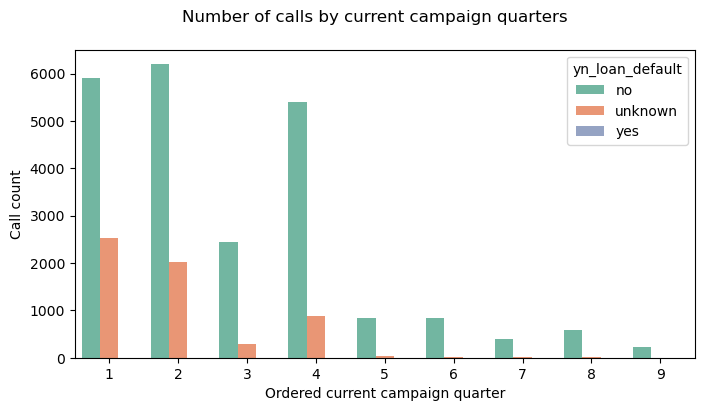

In [34]:
fig, ax = plt.subplots(figsize = (8,4))
fig.suptitle("Number of calls by current campaign quarters")

sns.countplot(data = X_train_prep
            , ax = ax
            , x = "campaign_quarter"
            , hue = "yn_loan_default"
             )

ax.set_xlabel("Ordered current campaign quarter")
ax.set_ylabel("Call count");

Trying to find a link between missingness in "yn_loan_default" and client characteristics like marital status, education, job, and age did not provide a straightforward connection. It has to be considered as missing not at random.


Looking at development of frequency of missingness through time showed only the obvious that the more calls are made the more likely it is to not get an answer. However, it did reveal something interesting about the dataset as a whole. More than a half of all calls happened in the first two quarters and around 90% of all calls were conducted in the first 4 quarters of the campaign.

In [35]:
# Fixing the initially noted data quality issue
X_train_prep["yn_loan_default_fix"] = np.where((X_train_prep["yn_house_loan"] == "no") & (X_train_prep["yn_pers_loan"] == "no") & \
                                         ((X_train_prep["yn_loan_default"] == "yes") | (X_train_prep["yn_loan_default"] == "unknown")), \
                                      "no",
                                      X_train_prep["yn_loan_default"]
                                    )

X_test_prep["yn_loan_default_fix"] = np.where((X_test_prep["yn_house_loan"] == "no") & (X_test_prep["yn_pers_loan"] == "no") & \
                                         ((X_test_prep["yn_loan_default"] == "yes") | (X_test_prep["yn_loan_default"] == "unknown")), \
                                      "no",
                                      X_test_prep["yn_loan_default"]
                                    )

pd.crosstab(index = [X_train_prep["yn_house_loan"], X_train_prep["yn_pers_loan"]]
          , columns = X_train_prep["yn_loan_default_fix"]
          , margins = True
           )

yn_loan_default_fix            no  unknown  yes    All
yn_house_loan yn_pers_loan                            
no            no            11264        0    0  11264
              yes            1404      391    0   1795
unknown       unknown         527        0    0    527
yes           no             9904     2494    1  12399
              yes            2100      507    0   2607
All                         25199     3392    1  28592

It is noteworthy that only 1 person (less than 0.0035% of the inverviewed population) has reported being in default. 

In general, people are reluctant to report financial difficulties.

Having this in mind, it is not possible to completely remove "unknown" label with the available data.

In [36]:
# Let's see by how much  the data quality of column "yn_loan_default" improved. Previously it was 20.82%
new_default_ratio = len(X_train_prep[X_train_prep["yn_loan_default_fix"]=="unknown"]) / len(X_train_prep)

print(f"After cleaning the column \"yn_loan_default_fix\" the participation of value \"unknown\" is {new_default_ratio*100:.2f}%")

After cleaning the column "yn_loan_default_fix" the participation of value "unknown" is 11.86%


#### Column "clients_job"

In [37]:
# Seeing if there is a link between item missingness for feature "clients_job" and feature "clients_education"
job_unknown = X_train_prep[X_train_prep["clients_job"] == "unknown"]

pd.crosstab(index = job_unknown["clients_job"]
          , columns = job_unknown["clients_education"]).sort_values(by = "unknown", axis = 1, ascending = False)

clients_education,unknown,basic.4y,high.school,university.degree,basic.9y,basic.6y,professional.course
clients_job,,,,,,,
unknown,40,34,29,28,17,15,9


In [38]:
# Seeing if there is a link between item missingness for feature "clients_job" and feature "clients_age"
pd.crosstab(index = job_unknown["clients_job"], columns = job_unknown["clients_age"]).sort_values(by="unknown", ascending=False, axis=1)

clients_age,53,44,35,45,43,32,34,46,58,49,...,25,40,61,62,63,65,69,72,76,78
clients_job,,,,,,,,,,,,,,,,,,,,,
unknown,13,10,9,9,8,8,8,7,6,6,...,1,1,1,1,1,1,1,1,1,1


In [39]:
# Seeing if there is a link between item missingness for feature "clients_job" and feature "clients_marital_status"
pd.crosstab(index = job_unknown["clients_job"], columns = job_unknown["clients_marital_status"]).sort_values(by="unknown",axis=1, ascending=False)

clients_marital_status,married,single,divorced,unknown
clients_job,,,,
unknown,125,39,5,3


In [40]:
# Seeing if there is a link between item missingness for feature "clients_job" and the time of the call
pd.crosstab(index = job_unknown["clients_job"], columns = job_unknown["campaign_day"]).sort_values(by="unknown", ascending=False, axis=1)

campaign_day,62,9,16,4,178,13,56,60,78,161,...,69,70,74,94,102,120,156,157,160,481
clients_job,,,,,,,,,,,,,,,,,,,,,
unknown,6,6,6,5,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1


Unfortunately, "unknown" value for feature "client_job" should be considered as missing not at random as well.

#### Column "clients_education"

In [41]:
edu_unknown = X_train_prep[X_train_prep["clients_education"] == "unknown"]
# Seeing if there is a link between item missingness for feature "clients_education" and feature "clients_job"
pd.crosstab(index=edu_unknown["clients_education"], columns=edu_unknown["clients_job"]).sort_values(by="unknown",axis=1, ascending=False)

clients_job,blue-collar,admin.,technician,student,services,management,retired,entrepreneur,unknown,housemaid,self-employed,unemployed
clients_education,,,,,,,,,,,,
unknown,324,165,146,114,107,80,60,40,40,24,19,17


In [42]:
# Seeing if there is a link between item missingness for feature "clients_education" and feature "clients_age"
pd.crosstab(index = edu_unknown["clients_education"], columns = edu_unknown["clients_age"]).sort_values(by="unknown", ascending=False, axis=1)

clients_age,45,41,42,36,38,30,35,47,39,34,...,71,74,70,68,80,81,83,84,67,61
clients_education,,,,,,,,,,,,,,,,,,,,,
unknown,56,51,44,42,41,39,35,33,33,32,...,2,1,1,1,1,1,1,1,1,1


In [43]:
# Seeing if there is a link between item missingness for feature "clients_education" and feature "clients_marital_status"
pd.crosstab(index = edu_unknown["clients_education"], columns = edu_unknown["clients_marital_status"]).sort_values(by="unknown",axis=1, ascending=False)

clients_marital_status,married,single,divorced
clients_education,,,
unknown,675,338,123


In [44]:
# Seeing if there is a link between item missingness for feature "clients_education" and the time of the call
pd.crosstab(index = edu_unknown["clients_education"], columns = edu_unknown["campaign_day"]).sort_values(by="unknown", ascending=False, axis=1)

campaign_day,54,151,105,75,1,19,32,7,58,51,...,240,233,230,222,217,205,201,196,195,489
clients_education,,,,,,,,,,,,,,,,,,,,,
unknown,29,24,24,22,22,21,21,20,20,19,...,1,1,1,1,1,1,1,1,1,1


Unfortunately, the analysis of "clients_marital_status" missingness did not provide significant information so it has to considered as missing not at random as well.

#### Column "yn_house_loan"

In [45]:
""" As seen when the analysis of feature "yn_loan_default" when yn_house_loan is unknown the yn_pers_loan is unknown as well. That's why it is sufficient to filter
    just based on one of them."""

loan_unknown = X_train_prep[X_train_prep["yn_house_loan"] == "unknown"]

# Seeing if there is a link between item missingness for feature "yn_house_loan" and feature "clients_job"
pd.crosstab(index=loan_unknown["yn_house_loan"], columns=loan_unknown["clients_job"]).sort_values(by="unknown",axis=1, ascending=False)

clients_job,admin.,blue-collar,technician,services,management,self-employed,retired,entrepreneur,unemployed,housemaid,student
yn_house_loan,,,,,,,,,,,
unknown,135,102,85,57,39,25,23,17,16,14,14


In [46]:
# Seeing if there is a link between item missingness for feature "yn_house_loan" and feature "clients_education"
pd.crosstab(index=loan_unknown["yn_house_loan"], columns=loan_unknown["clients_education"]).sort_values(by="unknown",axis=1, ascending=False)

clients_education,university.degree,high.school,basic.9y,professional.course,basic.4y,basic.6y
yn_house_loan,,,,,,
unknown,169,131,80,78,47,22


In [47]:
# Seeing if there is a link between item missingness for feature "yn_house_loan" and feature "clients_age"
pd.crosstab(index = loan_unknown["yn_house_loan"], columns = loan_unknown["clients_age"]).sort_values(by="unknown", ascending=False, axis=1)

clients_age,33,32,36,31,30,41,38,35,34,46,...,77,79,72,73,17,71,68,66,19,86
yn_house_loan,,,,,,,,,,,,,,,,,,,,,
unknown,39,36,27,23,22,22,22,20,18,18,...,1,1,1,1,1,1,1,1,1,1


In [48]:
# Seeing if there is a link between item missingness for feature "yn_house_loan" and feature "clients_marital_status"
pd.crosstab(index = loan_unknown["yn_house_loan"], columns = loan_unknown["clients_marital_status"]).sort_values(by="unknown",axis=1, ascending=False)

clients_marital_status,married,single,divorced
yn_house_loan,,,
unknown,295,164,68


In [49]:
# Seeing if there is a link between item missingness for feature "yn_house_loan" and the time of the call
pd.crosstab(index = loan_unknown["yn_house_loan"], columns = loan_unknown["campaign_day"]).sort_values(by="unknown", ascending=False, axis=1)

campaign_day,11,105,103,24,171,152,23,170,31,9,...,221,220,218,213,208,198,197,192,185,482
yn_house_loan,,,,,,,,,,,,,,,,,,,,,
unknown,13,11,11,10,10,9,9,9,9,9,...,1,1,1,1,1,1,1,1,1,1


Unfortunately, the analysis of "clients_marital_status" missingness did not provide significant information.

#### Column "clients_marital_status"

In [50]:
mar_unknown = X_train_prep[X_train_prep["clients_marital_status"] == "unknown"]

# Seeing if there is a link between item missingness for feature "clients_marital_status" and feature "clients_job"
pd.crosstab(index=mar_unknown["clients_marital_status"], columns=mar_unknown["clients_job"]).sort_values(by="unknown",axis=1, ascending=False)

clients_job,admin.,technician,blue-collar,services,self-employed,retired,unemployed,unknown,entrepreneur,housemaid,management,student
clients_marital_status,,,,,,,,,,,,
unknown,13,8,7,5,4,3,3,3,2,2,1,1


In [51]:
# Seeing if there is a link between item missingness for feature "clients_marital_status" and feature "clients_age"
pd.crosstab(index = mar_unknown["clients_marital_status"], columns = mar_unknown["clients_age"]).sort_values(by="unknown", ascending=False, axis=1)

clients_age,34,33,29,31,50,30,32,25,49,58,52,37,38,27,36,35,66,40,54,59
clients_marital_status,,,,,,,,,,,,,,,,,,,,
unknown,6,5,4,4,4,3,3,2,2,2,2,2,2,2,2,2,2,1,1,1


In [52]:
# Seeing if there is a link between item missingness for feature "clients_marital_status" and feature "clients_education"
pd.crosstab(index = mar_unknown["clients_marital_status"], columns = mar_unknown["clients_education"]).sort_values(by="unknown",axis=1, ascending=False)

clients_education,university.degree,high.school,basic.9y,professional.course,basic.6y,basic.4y
clients_marital_status,,,,,,
unknown,24,11,6,6,3,2


In [53]:
# Seeing if there is a link between item missingness for feature "clients_marital_status" and the time of the call
pd.crosstab(index = mar_unknown["clients_marital_status"], columns = mar_unknown["campaign_day"]).sort_values(by="unknown", ascending=False, axis=1)

campaign_day,166,69,105,19,161,32,178,219,51,169,...,4,104,55,31,30,18,16,11,5,455
clients_marital_status,,,,,,,,,,,,,,,,,,,,,
unknown,4,4,3,3,3,3,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1


Unfortunately, the analysis of "clients_marital_status" missingness did not provide significant information.

## Visualising dataset features

### 1. Economy indicators

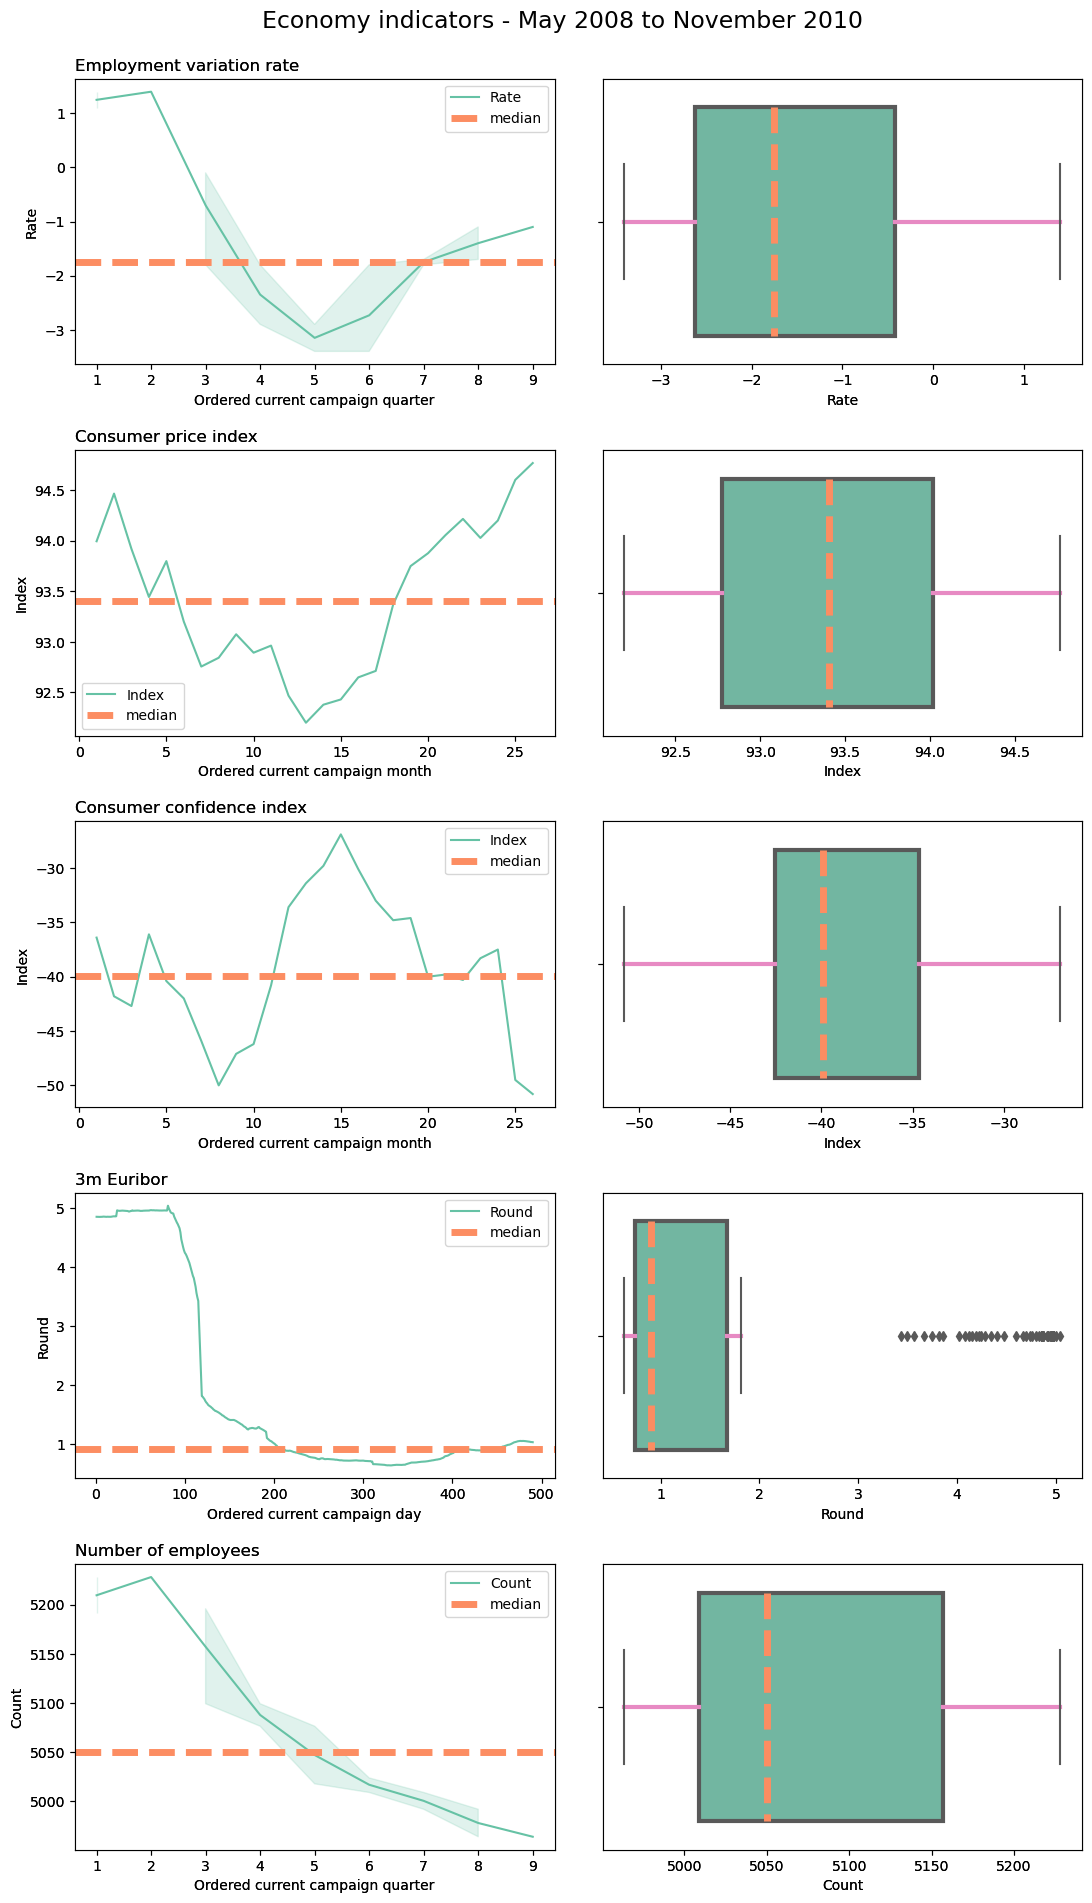

In [54]:
feat_list = ["employment_var_rate","cpi","cci","euribor3m","num_of_employees"]
feat_dict = {"employment_var_rate": 0,"cpi": 1,"cci": 2,"euribor3m": 3,"num_of_employees": 4}
title_dict = {"employment_var_rate": "Employment variation rate","cpi": "Consumer price index","cci": "Consumer confidence index",\
              "euribor3m": "3m Euribor","num_of_employees": "Number of employees"}
label_dict = {"employment_var_rate": "Rate","cpi": "Index","cci": "Index","euribor3m": "Round","num_of_employees": "Count"}
freq_dict = {"employment_var_rate": "campaign_quarter", "cpi": "campaign_month", "cci": "campaign_month", "euribor3m": "campaign_day", "num_of_employees": "campaign_quarter"}

box_cust = dict(linewidth = 3)
whisker_cust = dict(color = "#e78ac3", linewidth = 3, dash_capstyle = 'projecting')
median_cust = dict(color = "#fc8d62", linewidth = 5, ls="--")

boxplot_kwargs = {"boxprops": box_cust, "whiskerprops": whisker_cust, "medianprops": median_cust}

fig = plt.figure(figsize=(13, 23))
outer = gridspec.GridSpec(5, 1, wspace=0.1, hspace=0.3)
fig.suptitle("Economy indicators - May 2008 to November 2010", y=0.91, fontsize=17)

for feat in feat_list:
    i = feat_dict[feat]
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.2)

    for j in range(0,2):
        ax0 = plt.Subplot(fig, inner[0])
        econ_ind = X_train_prep.groupby(by=freq_dict[feat])[feat].value_counts().index
        t0 = sns.lineplot(ax=ax0, \
                          x=econ_ind.get_level_values(0),\
                          y=econ_ind.get_level_values(1))
        ax0.set_title(title_dict[feat], loc="left", fontsize=12)
        ax0.axhline(pd.Series(econ_ind.get_level_values(1)).median(), \
                    c="#fc8d62",\
                    ls="--",\
                    lw=5,\
                    label="median")
        ax0.legend(labels=[label_dict[feat], "median"])
        ax0.set_ylabel(ylabel=label_dict[feat])
        xlabel = freq_dict[feat].split("_")[1]
        xlabel = f"Ordered current campaign {xlabel}"
        ax0.set_xlabel(xlabel = xlabel)
        fig.add_subplot(ax0)
        
        ax1 = plt.Subplot(fig, inner[1])
        t1 = sns.boxplot(ax=ax1, x=econ_ind.get_level_values(1), **boxplot_kwargs)
        ax1.set_xlabel(xlabel = label_dict[feat])
        fig.add_subplot(ax1)

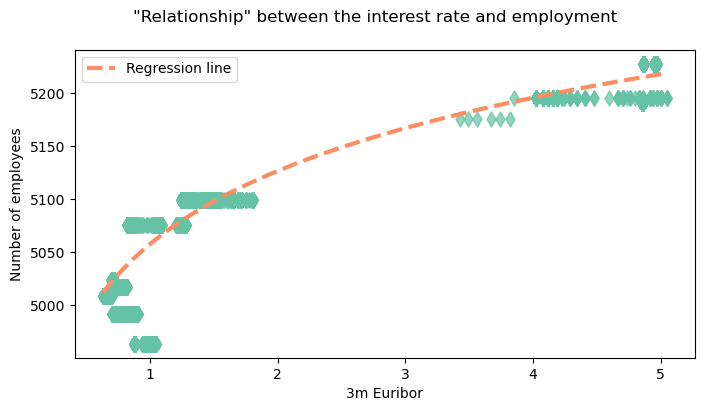

In [55]:
fig, ax = plt.subplots(figsize=(8,4))
fig.suptitle("\"Relationship\" between the interest rate and employment")

sns.regplot(data=X_train_prep, x="euribor3m", y="num_of_employees", logx=True, marker="d",
            line_kws={"color": "#fc8d62", "label": "Regression line", "linestyle": "--", "linewidth": 3},
            scatter_kws={"s": 60, "alpha": .7})
ax.set_xlabel("3m Euribor")
ax.set_ylabel("Number of employees")
ax.legend();

#### Conclusions:

1. About half of the observed period coincided with an expantionary monetary policy (decrease of 3m Euribor rate between days 80 and 350)

2. Consumer price index (CPI, inflation) jumps when money supply increases (when interest rates are lower). There seems to be some 5-6m lag to the changes in interest rates as interest rates started to constantly fall around day 100 while CPI started to rise constantly little pass day 200 (100 working days is around 5 calendar months). Noteworthy is that we do not know what year is taken as the base (index=100).

3. I've decided to leave that y-axis of Number of employees graph does not start with 0. This is done in order to see that there aren't any indescrepancies between it and Employment variation rate. From around quarter 2 we observe decrease in  Employment variaton rates and this is seen as well in the Number of employees graph. Additionally, from around quarter 7 the Empoyment rates are starting to move in opposite direction. However, they still indicate decrease in total workforce. This is also seen in the number of employees albeit with less significant rate of change.

4. Consumer confidence index seems to be driven by the movements of 3m Euribor and Number of employees. Initial low confidence is most likely driven by decrease in workforce. From around day 120 (after significant interest rate drop) confidence is on the rise as interest rates fall. However, as there is no reversal in employment trend the confidence weakens. With later introduction of rate increase confidence plummets.

5. Specifics of boxplots for these features is that their frequency is lower than client records (many during 1 day vs daily/monthly/quareterly). Boxplot-indicated outliers should not be removed as they are quite possible values that those indicators can take. What could come as a future step is to floor / cap the values for ML optimization.

6. It is interesting to see how a graph without proper background explanation could lead to false conclusions. The regression graph of "number of employees" and "3m Euribor" is showing possitive correlation (higher interest rates are linked to higher employment). This is counterintuitive as more expensive loans cannot lead to economy growth. One must understand that this is happening during financial and soverign crisis which had very bad impact on employment, that the observed period started with high interest rates because banks were quite reluctant to give out loans due to high uncertanty which was followed by aggresive and looser monetary policy by ECB but that it could not compansate for the drop in employment.

With high uncertainty it is difficult to have high expectations regarding peoples' willingness to make long-term deposits.

### 2. Visualisations of other numerical features

#### Age of clients

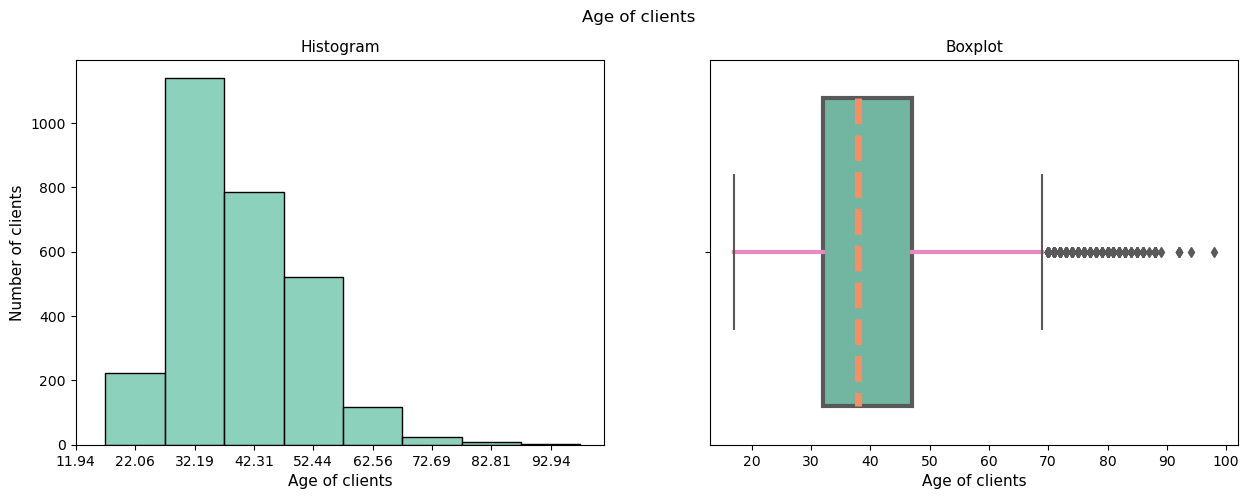

In [56]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
fig.suptitle("Age of clients")

# Histogram for age label
min_val = X_train_prep["clients_age"].min()
max_val = X_train_prep["clients_age"].max()
val_width = max_val - min_val
n_bins=8
bin_width = val_width/n_bins
sns.histplot(ax=axes[0], data=X_train_prep, x="clients_age",bins=n_bins,binrange=(min_val, max_val),stat="frequency",element="bars")
axes[0].set_title("Histogram", fontsize=11)
axes[0].set_xlabel(xlabel = "Age of clients", fontsize = 11)
axes[0].set_ylabel(ylabel = "Number of clients", fontsize = 11)
axes[0].set_xticks(np.arange(min_val-bin_width/2, max_val+bin_width/2, bin_width))

# Boxplot for age label
sns.boxplot(ax=axes[1], data=X_train_prep, x="clients_age", **boxplot_kwargs)
axes[1].set_title("Boxplot", fontsize=11)
axes[1].set_xlabel(xlabel = "Age of clients", fontsize = 11);

In [57]:
pd.DataFrame(X_train_prep["clients_age"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
clients_age,28592.0,39.970271,10.383427,17.0,32.0,38.0,47.0,98.0


In [58]:
IQR = X_train_prep["clients_age"].describe().loc["75%"] - X_train_prep["clients_age"].describe().loc["25%"]
up_range = X_train_prep["clients_age"].describe().loc["75%"] + 1.5 * IQR
print(f"The upper outlier boundry for client age is {up_range} years.")

The upper outlier boundry for client age is 69.5 years.


In [59]:
# Distribution of outcome for older clients
fltr_old = X_train_prep[X_train_prep["clients_age"] > up_range].index
y_train_df = pd.DataFrame(y_train)
#pd.DataFrame(y_train).loc(axis=1)[fltr_old, "y"].value_counts(normalize=True)
y_train_df.loc[fltr_old, :].value_counts(normalize=True)

y
0    0.55873
1    0.44127
dtype: float64

In [60]:
# Label Y across whole dataset
y_train.value_counts(normalize=True)

0    0.886961
1    0.113039
Name: y, dtype: float64

Histogram is showing that the customers' age is a right-skewed feature, meaning most of the clients are younger.
Median is 38 years, while mean is 40 years.

Although boxplot of "age" feature indicates that customers with age above 69.5 are to be considered outliers, data says that 44% of that age group is willing to place a deposit. 

When compared to the participation of positive outcome for the whole dataset, it can be seen that people older than 69.5 years agreed to the sales agent's proposal around 4 times more often.

However, an ethical question arises if people this old should be called given that they are more susceptible to outside influence. This should be discussed with management.

#### Number of calls per client during current campaign

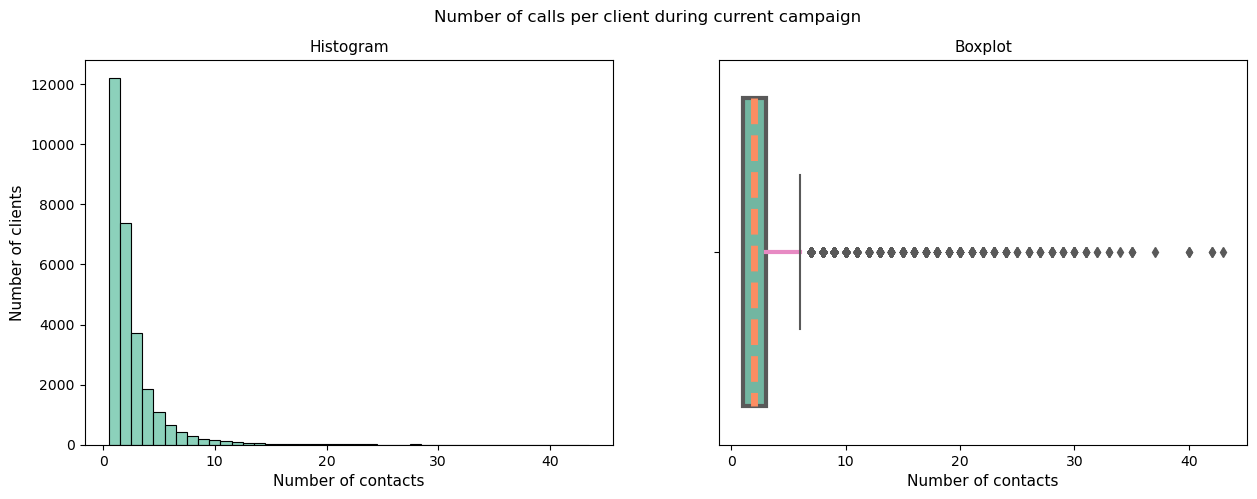

In [61]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
fig.suptitle("Number of calls per client during current campaign")

# Histogram for campaign label
sns.histplot(ax=axes[0], data=X_train_prep, x="curr_camp_num_calls",bins=15,stat="frequency",element="bars", discrete=True)
axes[0].set_title("Histogram", fontsize=11)
axes[0].set_xlabel(xlabel = "Number of contacts", fontsize = 11)
axes[0].set_ylabel(ylabel = "Number of clients", fontsize = 11);

# Boxplot for campaign label
sns.boxplot(ax=axes[1], data=X_train_prep, x="curr_camp_num_calls", **boxplot_kwargs)
axes[1].set_title("Boxplot", fontsize=11)
axes[1].set_xlabel(xlabel = "Number of contacts", fontsize = 11);

In [62]:
IQR = X_train_prep["curr_camp_num_calls"].describe().loc["75%"] - X_train_prep["curr_camp_num_calls"].describe().loc["25%"]
up_range = X_train_prep["curr_camp_num_calls"].describe().loc["75%"] + 1.5 * IQR
print(f"The upper outlier boundry for number of calls during current campaign is {up_range.astype(int)} calls.")

The upper outlier boundry for number of calls during current campaign is 6 calls.


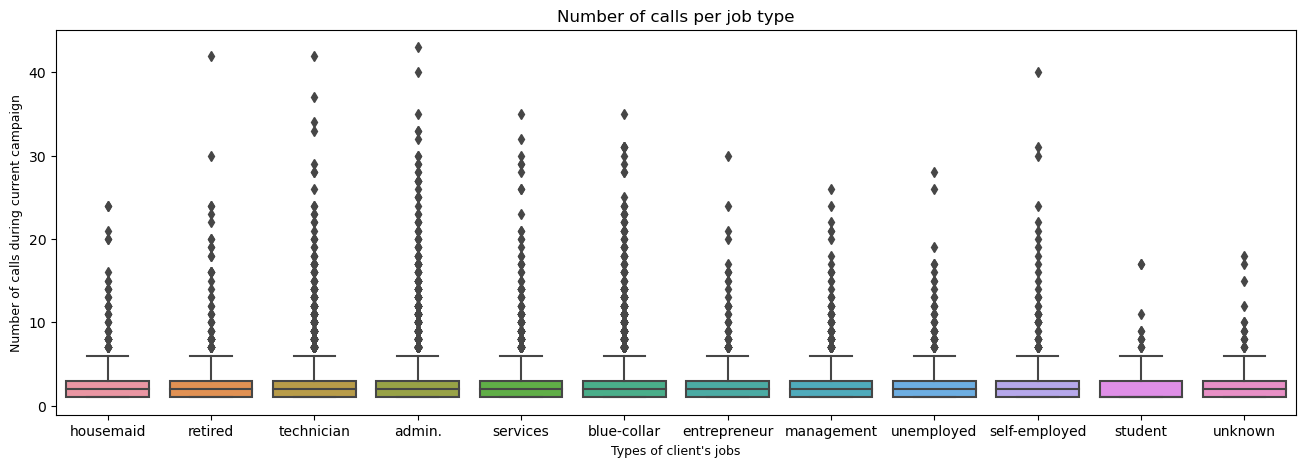

In [63]:
# Number of current campaign calls per job type
fig, ax = plt.subplots(figsize=(16,5))
sns.boxplot(data = X_train_prep, 
            x = "clients_job", 
            y = "curr_camp_num_calls")
ax.set_title("Number of calls per job type", fontsize=12)
ax.set_ylabel("Number of calls during current campaign", fontsize=9)
ax.set_xlabel("Types of client's jobs", fontsize=9);

On average no particular job type was called more while outliers (still questionable) are with clients that are in administration, blue-collar, and technicians

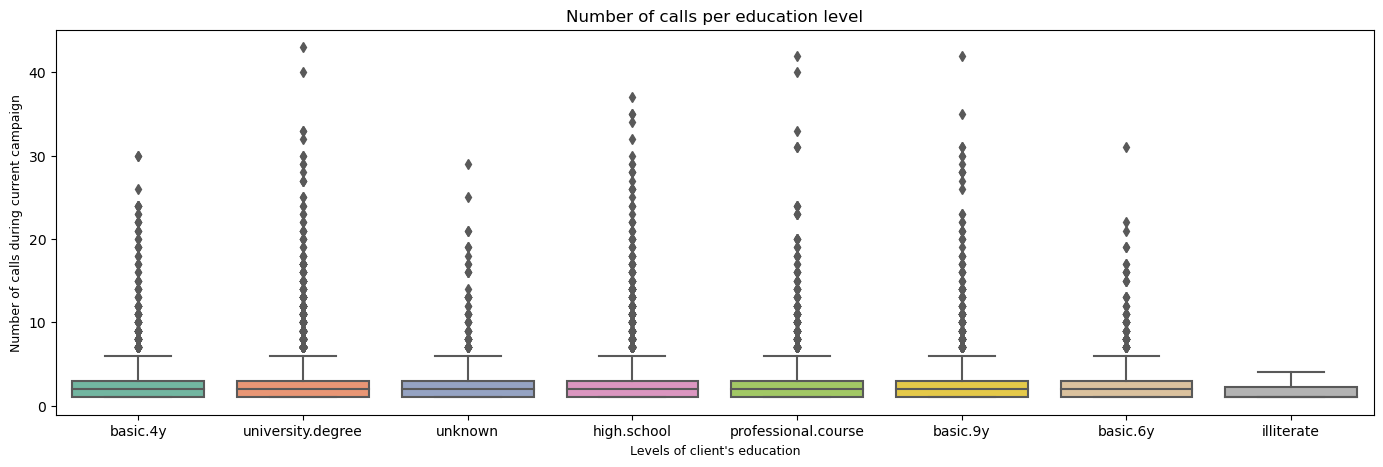

In [64]:
# Number of current campaign calls per education level
fig, ax = plt.subplots(figsize=(17,5))
sns.boxplot(data = X_train_prep, 
            x = "clients_education", 
            y = "curr_camp_num_calls")
ax.set_title("Number of calls per education level", fontsize=12)
ax.set_ylabel("Number of calls during current campaign", fontsize=9)
ax.set_xlabel("Levels of client's education", fontsize=9);

On average no particular educational level was called more while call center employees were "giving up" sooner on those that are illiterate.

#### Number of calls per client during previous campaign

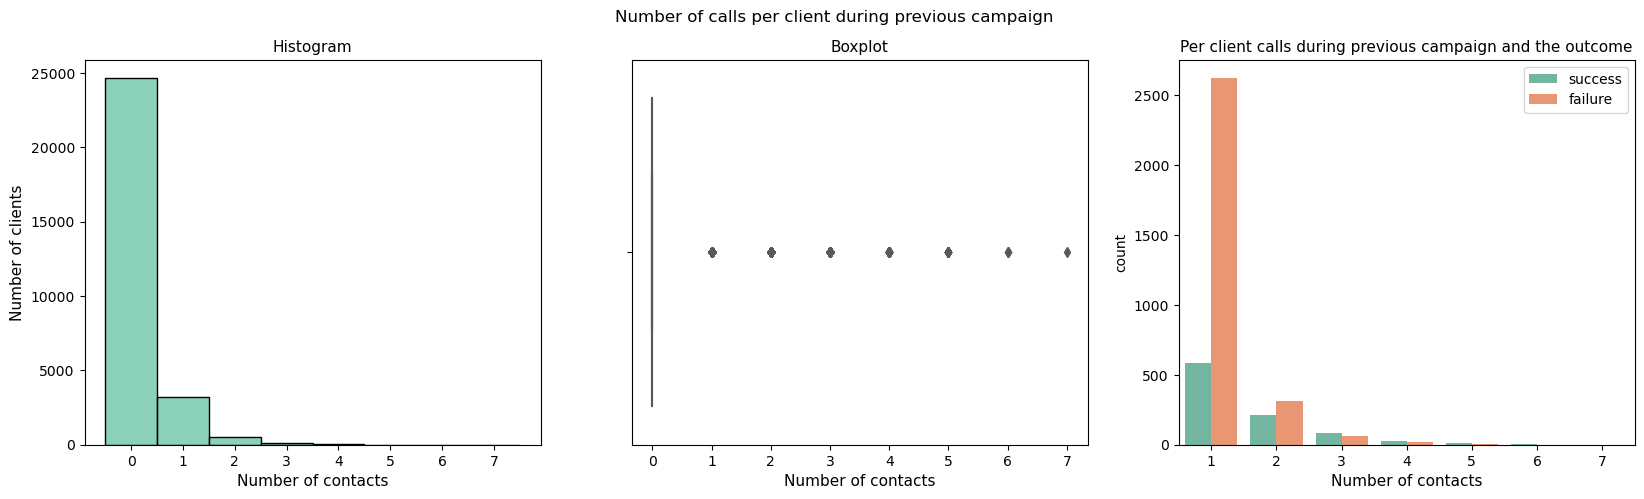

In [65]:
fig, axes = plt.subplots(1,3,figsize=(20, 5))
fig.suptitle("Number of calls per client during previous campaign")

# Histogram for previous label
sns.histplot(ax = axes[0], data = X_train_prep, x = "prev_camp_num_calls", bins = 8, stat = "frequency", element = "bars", discrete = True)
axes[0].set_title("Histogram", fontsize = 11)
axes[0].set_xlabel(xlabel = "Number of contacts", fontsize = 11)
axes[0].set_ylabel(ylabel = "Number of clients", fontsize = 11);

# Boxplot for previous label
sns.boxplot(ax=axes[1], data=X_train_prep, x="prev_camp_num_calls")
axes[1].set_title("Boxplot", fontsize=11)
axes[1].set_xlabel(xlabel = "Number of contacts", fontsize = 11)

# Side-by-side barplot for previous and poutcome labels
fltr_pre = X_train_prep["prev_camp_num_calls"] != 0
df1 = X_train_prep.loc[fltr_pre]
sns.countplot(ax=axes[2], data=df1, x="prev_camp_num_calls", hue="prev_camp_outcome")
axes[2].set_title("Per client calls during previous campaign and the outcome", fontsize=11)
axes[2].set_xlabel("Number of contacts", fontsize=11)
axes[2].legend(loc="upper right");

The number of clients that were not contacted before the most recent one is so large that all other values are classified as outlier by the boxplot. The ratio of made previous calls and current success seems best for 2 and 3 previously made calls.

In [66]:
# In order to speed up the process of graph generation I will rearrange the columns of the dataset
corr_order = ['clients_job', 'clients_marital_status', 'clients_education', 'yn_loan_default_fix', 'yn_house_loan', 'yn_pers_loan', 'contact_channel'
            , 'month_of_last_contact', 'weekday_of_last_contact', 'true_num_days_since_last_contact_cat', 'prev_camp_outcome', 'clients_age'
            , 'employment_var_rate', 'cpi', 'cci', 'euribor3m', 'num_of_employees', 'duration_of_last_contact', 'curr_camp_num_calls', 'num_days_since_last_contact'
            , 'prev_camp_num_calls', 'campaign_day', 'campaign_month', 'campaign_quarter', 'campaign_year', 'true_num_days_since_last_contact', 'yn_loan_default'] 
 
X_train_prep = X_train_prep[corr_order]
X_train_prep.head()

,clients_job,clients_marital_status,clients_education,yn_loan_default_fix,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,true_num_days_since_last_contact_cat,...,duration_of_last_contact,curr_camp_num_calls,num_days_since_last_contact,prev_camp_num_calls,campaign_day,campaign_month,campaign_quarter,campaign_year,true_num_days_since_last_contact,yn_loan_default
22844,housemaid,married,basic.4y,no,yes,no,cellular,aug,mon,not contacted before,...,132,1,999,0,76,4,2,2008,999,no
38491,retired,married,basic.4y,no,yes,no,cellular,oct,tue,contacted long ago,...,102,1,6,2,271,15,6,2009,225,no
6495,retired,married,basic.4y,unknown,yes,yes,telephone,may,wed,not contacted before,...,571,1,999,0,17,1,1,2008,999,unknown
37483,housemaid,married,university.degree,no,no,yes,cellular,aug,thu,contacted long ago,...,1152,2,6,1,220,13,5,2009,276,no
8423,technician,married,unknown,no,no,no,telephone,jun,tue,not contacted before,...,131,4,999,0,21,2,1,2008,999,no


In [67]:
# Doing the same for the test dataset

X_test_prep = X_test_prep[corr_order]
X_test_prep.head()

,clients_job,clients_marital_status,clients_education,yn_loan_default_fix,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,true_num_days_since_last_contact_cat,...,duration_of_last_contact,curr_camp_num_calls,num_days_since_last_contact,prev_camp_num_calls,campaign_day,campaign_month,campaign_quarter,campaign_year,true_num_days_since_last_contact,yn_loan_default
37443,retired,married,basic.6y,no,no,no,cellular,aug,wed,not contacted before,...,174,1,999,0,219,13,5,2009,999,unknown
16665,admin.,married,professional.course,no,yes,no,cellular,jul,wed,not contacted before,...,322,3,999,0,55,3,2,2008,999,no
6062,blue-collar,married,basic.4y,no,no,no,telephone,may,tue,not contacted before,...,115,1,999,0,16,1,1,2008,999,no
26211,blue-collar,divorced,basic.9y,no,unknown,unknown,cellular,nov,thu,not contacted before,...,73,3,999,0,105,6,3,2008,999,no
13086,admin.,married,university.degree,no,yes,no,cellular,jul,tue,not contacted before,...,183,5,999,0,44,3,2,2008,999,no


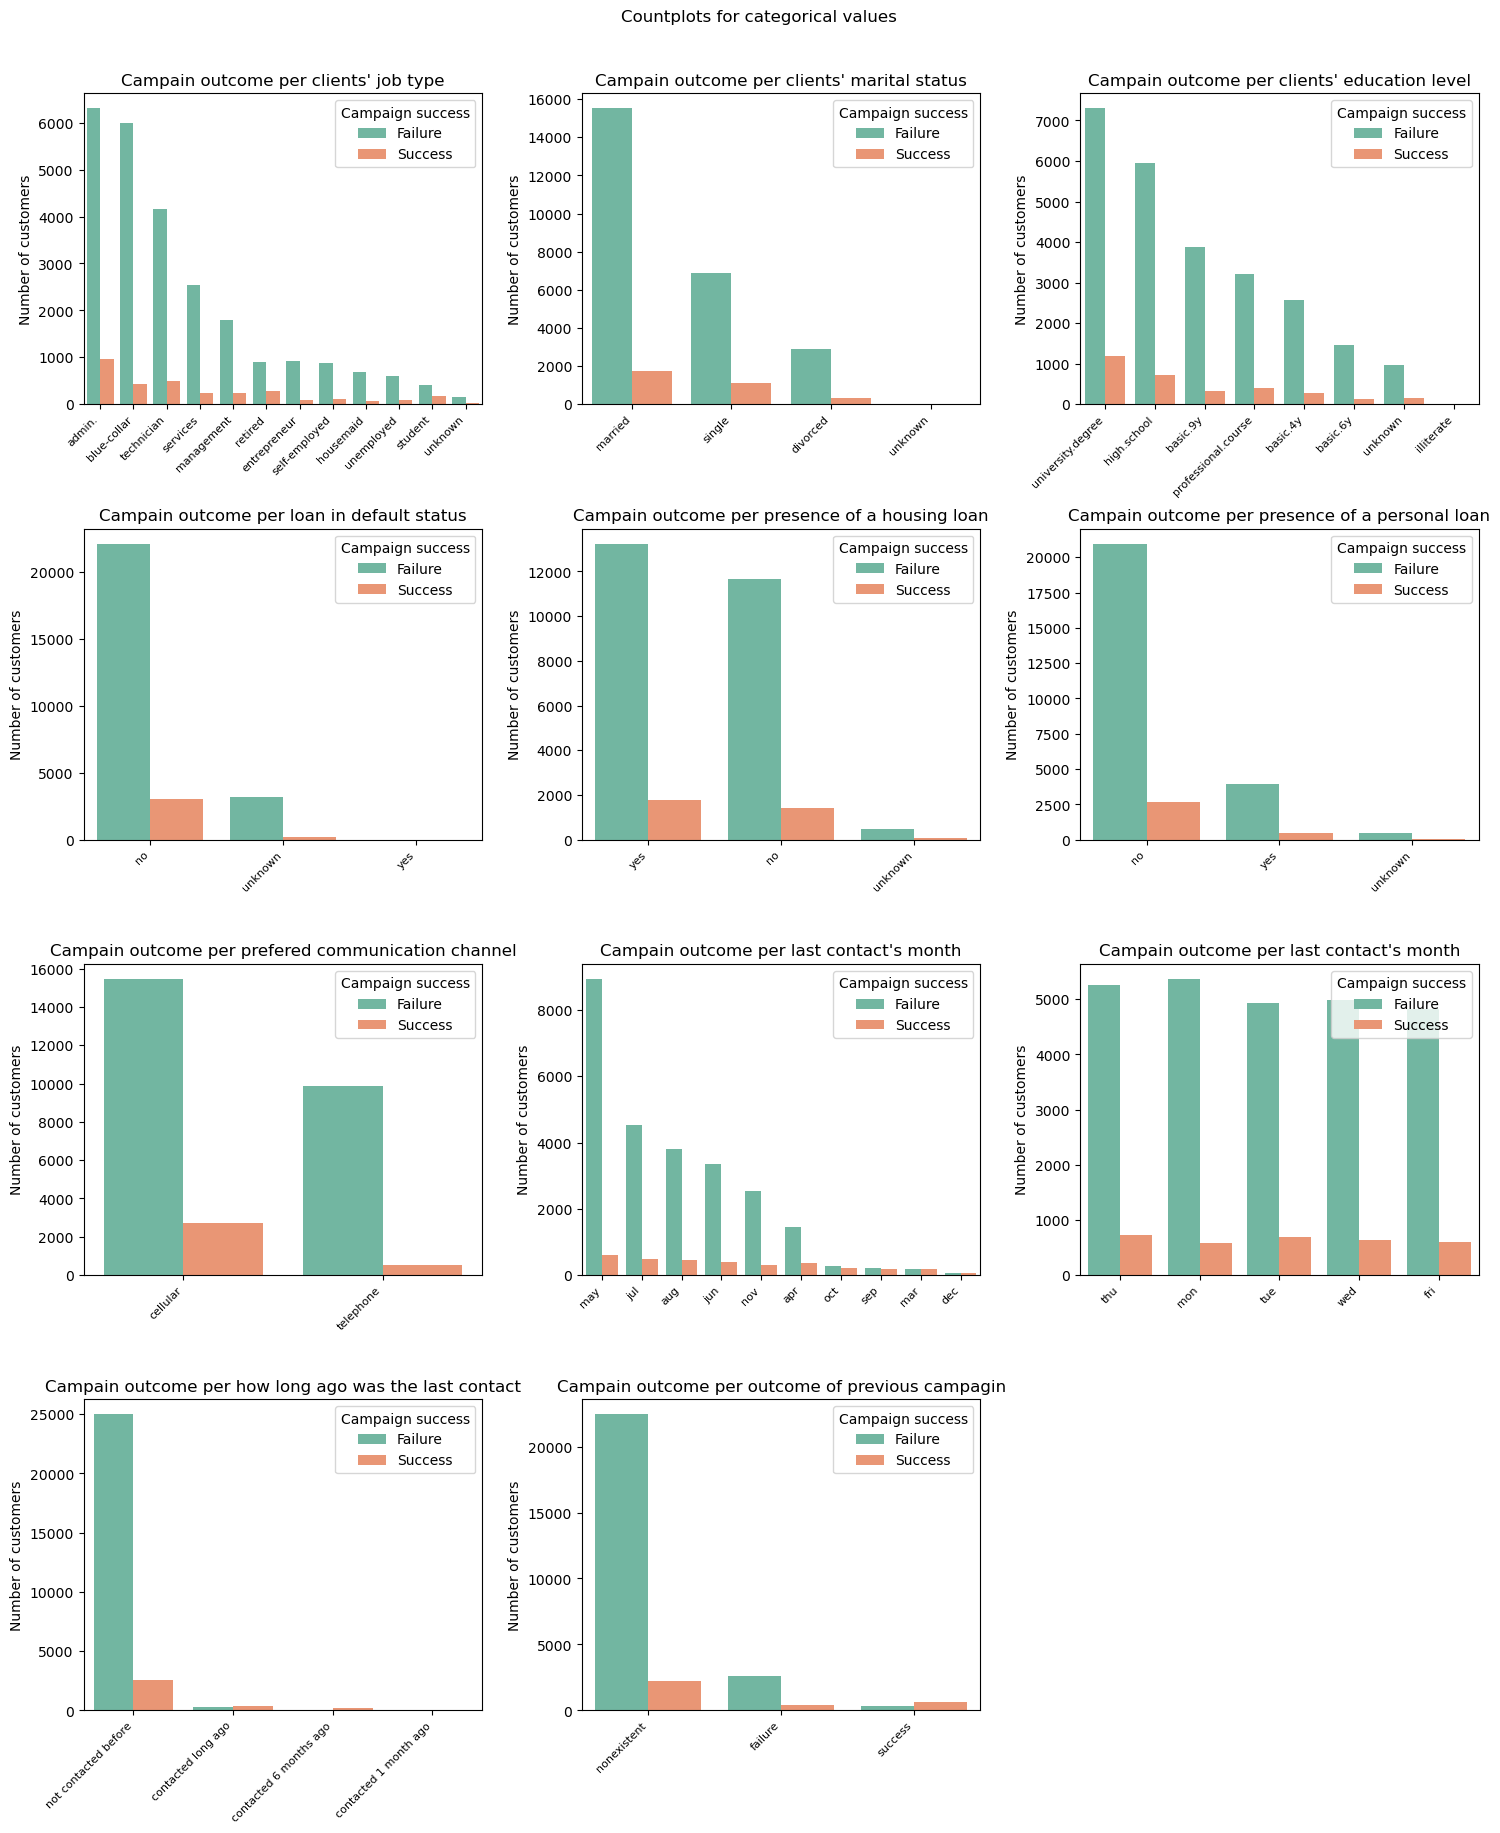

In [68]:
df_hue = pd.merge(X_train_prep, y_train, left_index=True, right_index=True)

fig, axes = plt.subplots(4,3, figsize=(18,21))
fig.delaxes(axes[3,2])
fig.suptitle("Countplots for categorical values", y=0.92)

n=0
for i in [0,1,2,3]:
    for j in [0,1,2]:        
        sns.countplot(ax=axes[i,j], data=df_hue, x=df_hue.columns[i+j+n], hue="y", order=df_hue.iloc[:,i+j+n].value_counts().sort_values(ascending=False).index)
        axes[i,j].set_xticklabels(rotation=45, ha="right", labels=df_hue.iloc[:,i+j+n].value_counts().sort_values(ascending=False).index, fontsize=8)
        axes[i,j].set_ylabel("Number of customers")
        axes[i,j].set_xlabel("")
        axes[i,j].legend(title='Campaign success', loc="upper right", labels=["Failure", "Success"])
    n+=2

axes[0,0].set_title("Campain outcome per clients' job type")
axes[0,1].set_title("Campain outcome per clients' marital status")
axes[0,2].set_title("Campain outcome per clients' education level")
axes[1,0].set_title("Campain outcome per loan in default status")
axes[1,1].set_title("Campain outcome per presence of a housing loan")
axes[1,2].set_title("Campain outcome per presence of a personal loan")
axes[2,0].set_title("Campain outcome per prefered communication channel")
axes[2,1].set_title("Campain outcome per last contact's month")
axes[2,2].set_title("Campain outcome per last contact's month")
axes[3,0].set_title("Campain outcome per how long ago was the last contact")
axes[3,1].set_title("Campain outcome per outcome of previous campagin")
plt.subplots_adjust(hspace=.4, wspace=.25);

Some observations based on categorical features:
- In absolute terms the campaign was most successful with clients that work in administration. However, in relative terms best are retired (but having in mind previous ethical concern) and students.
- In absolute terms the campaign was most successful with clients that are married. However, in relative terms it was most successful with single clients.
- Housing loan and consumer loan do not seem to be a deciding factor
- Mobile phone seems to be a communication channel of choice for those that accepted to place the term deposit.
- September through March seems to be the best period for the campaign given the relative success rate
- During the second half of the work-week people seem to be a bit more open to the campaign offer
- Previously contacted people are familiar with the campaign and are more open for it.
- Success breeds success

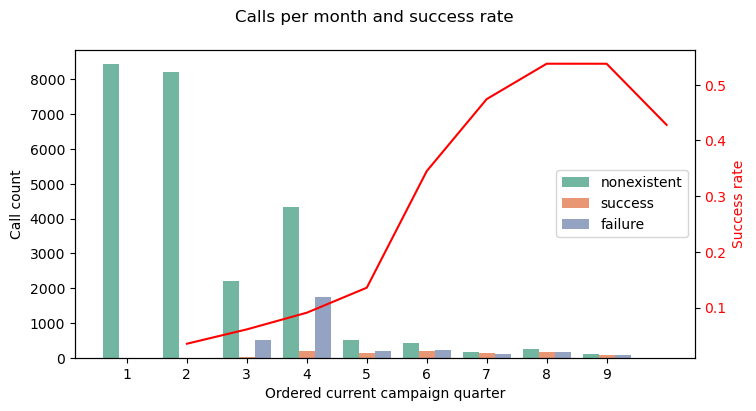

In [69]:
# Success rate of calls per month of current campaign
fig, ax = plt.subplots(figsize=(8,4))
fig.suptitle("Calls per month and success rate")
succ_flag = df_hue["y"]==1
succ_rate = pd.Series(df_hue.loc[succ_flag, :].groupby(by="campaign_quarter")["y"].count()/df_hue.groupby(by="campaign_quarter")["y"].count())

ax1 = sns.countplot(data=df_hue, ax=ax, x="campaign_quarter", hue="prev_camp_outcome")
ax.set_xlabel("Ordered current campaign quarter")
ax.set_ylabel("Call count")
ax.legend(loc=("center right"))

ax2 = ax1.twinx()

sns.lineplot(data=succ_rate, x=succ_rate.index, y=succ_rate, ax=ax2, legend=True, color="red")
ax2.set_ylabel("Success rate", color="red")
ax2.tick_params(axis="y", labelcolor="red");

The graph is showing that in the first two quarters of campaign the call center colleagues were calling only previously never contacted people. As numbers of such clients was falling down they had to start turning to previously contacted as well. At first, mainly to those that did not accept the offer from the previuos campaign. And at last, they started reaching out to people who did accept the offer from the previuos campaign (probably their deposit was soon to expire and they were asked if they would like to renew it).

The success rate curve that is plotted on top shows that even exposure to the previous campaign seems like a strong indicator of success in the most recent campaign.

Maybe it would be beneficial to group failure and success outcomes as one group and nonexistent as the other in the feature engineering part of model building.

## Data consistency and data quality

The values "not contacted before" in "true_num_days_since_last_contact_cat" should represent same kind of information like "nonexistent" in "prev_camp_outcome". And the same can be said about value 0 in the column "prev_camp_num_calls".
However, the counts differ. Best is compare the definitions once again and confirm count using "value_counts()"

In [70]:
from operator import itemgetter 
itemgetter("num_days_since_last_contact","prev_camp_num_calls","prev_camp_outcome")(feature_desc)

('number of days that passed by after the client was last contacted from previous campaign, 999 not contacted before (num)',
 'number of contacts pefromed before this campaign and for this client (num)',
 'outcome of the previous marketing campaign (cat)')

In [71]:
# Displaying dataframes side-by-side
from IPython.display import display_html

true_num_days_since_last_contact_cat = pd.DataFrame(X_train_prep["true_num_days_since_last_contact_cat"].value_counts(ascending=False))
prev_camp_num_calls = pd.DataFrame(X_train_prep["prev_camp_num_calls"].value_counts(ascending=False))
prev_camp_outcome = pd.DataFrame(X_train_prep["prev_camp_outcome"].value_counts(ascending=False))

df1_styler = true_num_days_since_last_contact_cat.style.set_table_attributes("style='display:inline'").set_caption('True days past previous contact')
df2_styler = prev_camp_num_calls.style.set_table_attributes("style='display:inline'").set_caption('Number of calls during previous campaign')
df3_styler = prev_camp_outcome.style.set_table_attributes("style='display:inline'").set_caption('Outcome of the previous campaign')
space = "\xa0"*30

display_html(df1_styler._repr_html_() + space + df2_styler._repr_html_() + space + df3_styler._repr_html_(), raw=True)

,true_num_days_since_last_contact_cat
not contacted before,27575
contacted long ago,677
contacted 6 months ago,308
contacted 1 month ago,32
,prev_camp_num_calls
0,24651
1,3208
2,526
3,148
4,42


There are some 2900 deals for which "true_num_days_since_last_contact_cat" tells that the client was not contacted before but two other columns (prev_camp_num_calls and prev_camp_outcome) tell the opposite. Given that its 2 vs 1 I need to make a change in the dataset.

For these 2900 deals I will assign median of "num_days_since_last_contact" for records that are available.
This median will be used to create new columns:
- "days_since_last_contact" -> updated values from num_days_since_last_contact and
- "last_contact" -> updated values from true_num_days_since_last_contact_cat

In [72]:
fltr_exist = (X_train_prep["true_num_days_since_last_contact_cat"] != "not contacted before")
test = X_train_prep.loc[fltr_exist, "num_days_since_last_contact"]
median_pdays = test.median().astype(int)

In [73]:
X_train_prep["days_since_last_contact"] = np.where((X_train_prep["true_num_days_since_last_contact_cat"] == "not contacted before") & (X_train_prep["prev_camp_outcome"] != "nonexistent"),\
                                          total_days-X_train_prep["campaign_day"]+median_pdays,\
                                          X_train_prep["num_days_since_last_contact"])

last_contact = pd.cut(X_train_prep["days_since_last_contact"],bins=bins,labels=categories)
X_train_prep["last_contact"] = last_contact
X_train_prep.head(2)

,clients_job,clients_marital_status,clients_education,yn_loan_default_fix,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,true_num_days_since_last_contact_cat,...,num_days_since_last_contact,prev_camp_num_calls,campaign_day,campaign_month,campaign_quarter,campaign_year,true_num_days_since_last_contact,yn_loan_default,days_since_last_contact,last_contact
22844,housemaid,married,basic.4y,no,yes,no,cellular,aug,mon,not contacted before,...,999,0,76,4,2,2008,999,no,999,not contacted before
38491,retired,married,basic.4y,no,yes,no,cellular,oct,tue,contacted long ago,...,6,2,271,15,6,2009,225,no,6,contacted 1 month ago


In [74]:
# Checking the if the change was successful. Expecting that number of previously not contacted clients is 35.245
X_train_prep["last_contact"].value_counts()

not contacted before      24651
contacted long ago         2685
contacted 1 month ago      1042
contacted 6 months ago      214
Name: last_contact, dtype: int64

In [75]:
# Making the same changes to the test dataset.
# Important: using train data set median value for the test data

X_test_prep["days_since_last_contact"] = np.where((X_test_prep["true_num_days_since_last_contact_cat"] == "not contacted before") & (X_test_prep["prev_camp_outcome"] != "nonexistent"),\
                                          total_days-X_test_prep["campaign_day"]+median_pdays,\
                                          X_test_prep["num_days_since_last_contact"])

last_contact = pd.cut(X_test_prep["days_since_last_contact"],bins=bins,labels=categories)
X_test_prep["last_contact"] = last_contact
X_test_prep.head(2)

,clients_job,clients_marital_status,clients_education,yn_loan_default_fix,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,true_num_days_since_last_contact_cat,...,num_days_since_last_contact,prev_camp_num_calls,campaign_day,campaign_month,campaign_quarter,campaign_year,true_num_days_since_last_contact,yn_loan_default,days_since_last_contact,last_contact
37443,retired,married,basic.6y,no,no,no,cellular,aug,wed,not contacted before,...,999,0,219,13,5,2009,999,unknown,999,not contacted before
16665,admin.,married,professional.course,no,yes,no,cellular,jul,wed,not contacted before,...,999,0,55,3,2,2008,999,no,999,not contacted before


In [76]:
# Selectinng feature scope for training data after DQ cleaning

df1 = X_train_prep[['clients_job','clients_marital_status','clients_education','yn_loan_default_fix','yn_house_loan', 'yn_pers_loan','contact_channel','month_of_last_contact',\
           'weekday_of_last_contact','prev_camp_outcome','clients_age','employment_var_rate','cpi','cci','euribor3m','num_of_employees', 'curr_camp_num_calls',\
           'prev_camp_num_calls','last_contact']]
X_train = df1.copy()
X_train.rename({"yn_loan_default_fix": "yn_loan_default"}, axis=1, inplace=True)
X_train.head(2)

,clients_job,clients_marital_status,clients_education,yn_loan_default,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,prev_camp_outcome,clients_age,employment_var_rate,cpi,cci,euribor3m,num_of_employees,curr_camp_num_calls,prev_camp_num_calls,last_contact
22844,housemaid,married,basic.4y,no,yes,no,cellular,aug,mon,nonexistent,48,1.4,93.444,-36.1,4.965,5228.1,1,0,not contacted before
38491,retired,married,basic.4y,no,yes,no,cellular,oct,tue,success,68,-3.4,92.431,-26.9,0.728,5017.5,1,2,contacted 1 month ago


In [77]:
# Selectinng feature scope for test data after DQ cleaning

df2 = X_test_prep[['clients_job','clients_marital_status','clients_education','yn_loan_default_fix','yn_house_loan', 'yn_pers_loan','contact_channel','month_of_last_contact',\
           'weekday_of_last_contact','prev_camp_outcome','clients_age','employment_var_rate','cpi','cci','euribor3m','num_of_employees', 'curr_camp_num_calls',\
           'prev_camp_num_calls','last_contact']]

X_test = df2.copy()
X_test.rename({"yn_loan_default_fix": "yn_loan_default"}, axis=1, inplace=True)
X_test.head(2)

,clients_job,clients_marital_status,clients_education,yn_loan_default,yn_house_loan,yn_pers_loan,contact_channel,month_of_last_contact,weekday_of_last_contact,prev_camp_outcome,clients_age,employment_var_rate,cpi,cci,euribor3m,num_of_employees,curr_camp_num_calls,prev_camp_num_calls,last_contact
37443,retired,married,basic.6y,no,no,no,cellular,aug,wed,nonexistent,66,-2.9,92.201,-31.4,0.879,5076.2,1,0,not contacted before
16665,admin.,married,professional.course,no,yes,no,cellular,jul,wed,nonexistent,35,1.4,93.918,-42.7,4.963,5228.1,3,0,not contacted before


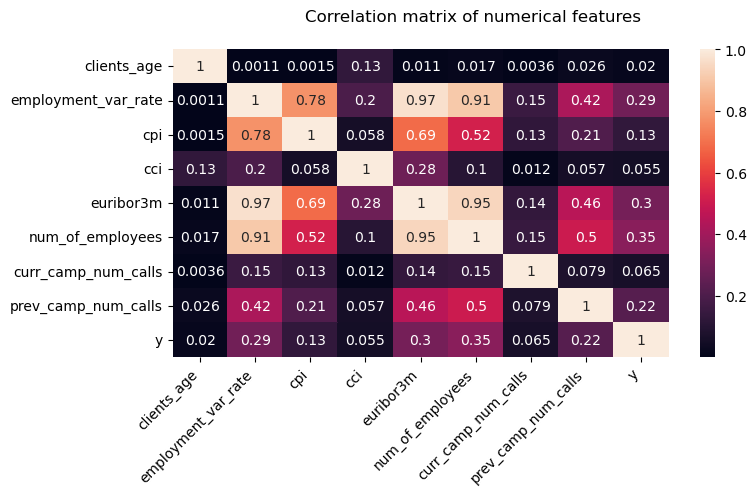

In [78]:
fig, ax = plt.subplots(figsize=(8,4))
fig.suptitle("Correlation matrix of numerical features")

train = pd.merge(X_train, y_train, left_index=True, right_index=True)
corr_matrix = train.corr().abs()
sns.heatmap(corr_matrix, annot=True, fmt=".2g")
plt.xticks(rotation=45, horizontalalignment="right");

Features "employment_variaton_rate", "num_of_employees" and "euribor3m" are highly correlated with coefficionts of correlation being over 0.90.

I will keep the one that has the highest coefficient of correlation with the target variable ("y"). This is num_of_employees with correlation coefficient 0.35.

I will drop "employment_variaton_rate" and "euribor3m".

In [79]:
# Dropping highly correlated features in both training and test set

X_train.drop(columns=["employment_var_rate", "euribor3m"], inplace=True)
X_test.drop(columns=["employment_var_rate", "euribor3m"], inplace=True)

## Feature engineering

### Creating training and holdout subsets

### Description of planned approach per feature

`clients_job`, `clients_education`: RareLabelEncoder() (4% threshold) + OrdnalEncoder()

`clients_marital_status`, `yn_house_loan`, and `yn_pers_loan`: for "unknown" I will apply simple imputer with strategy="most_frequent" + OrdnalEncoder()

`contact_channel`, `last_contact`, and `yn_loan_default`: sklearn OrdnalEncoder()

`clients_age` and `curr_camp_num_calls`: Winsorizer() + StandardScaler()

`cpi`, `cci`, `num_of_employees`: StandardScaler()

`month_of_last_contact`, `weekday_of_last_contact`: category_encoders OrdinalEncoder()

`prev_camp_outcome`: apply the previously observed behaviour through lambda function as Function transformer I was not able to call through pipeline

`prev_camp_num_calls`: leave it as it is

In [80]:
feature_order = [{"col":"month_of_last_contact",
                  "mapping": {"mar":1,"apr":2,"may":3,"jun":4,"jul":5, "aug": 6, "sep": 7, "oct": 8, "nov": 9, "dec": 10}
                 },
                 {"col": "weekday_of_last_contact",
                  "mapping": {"mon": 1, "tue": 2, "wed": 3, "thu": 4, "fri": 5}
                 }
                ]

In [81]:
col_trans = {
             "ct_pipe_1": {"ct_1_1": {"rare":       ["clients_job", "clients_education"]}, 
                           "ct_1_2": {"no_order":   ["clients_job", "clients_education"]}},
             "ct_pipe_2": {"ct_2_1": {"simple":     ["clients_marital_status", "yn_house_loan", "yn_pers_loan"]}, 
                           "ct_2_2": {"no_order":   ["clients_marital_status", "yn_house_loan", "yn_pers_loan"]}},
             "ct_pipe_3": {"ct_3_1": {"no_order":   ["contact_channel", "last_contact", "yn_loan_default"]}},
             "ct_pipe_4": {"ct_4_1": {"winsorizer": ["clients_age", "curr_camp_num_calls"]},
                           "ct_4_2": {"stdscr":     ["clients_age", "curr_camp_num_calls"]}},
             "ct_pipe_5": {"ct_5_1": {"stdscr":     ["cpi", "cci", "num_of_employees"]}},
             "ct_pipe_6": {"ct_6_1": {"order":      ["month_of_last_contact", "weekday_of_last_contact"]}},
             "no_transformation": ["prev_camp_outcome", "prev_camp_num_calls"]
             }      

In [82]:
# Defining feature engineering pipelines and column transformers
ct_pipe_1 = Pipeline([
                        ("rare",    RareLabelEncoder(tol = 0.04, replace_with = "Rare")),
                        ("no_order", no_order_encoder())
                    ])

ct_pipe_2 = Pipeline([
                        ("simple",  SimpleImputer(missing_values = "unknown", strategy = "most_frequent")),
                        ("no_order", no_order_encoder())
                    ])

ct_pipe_3 = Pipeline([ 
                        ("no_order", no_order_encoder())
                    ])

ct_pipe_4 = Pipeline([
                        ("winsorizer",  Winsorizer(capping_method = 'iqr', fold = 1.5, tail = 'right')),
                        ("stdscr",      StandardScaler())
                    ])

ct_pipe_5 = Pipeline([ 
                        ("stdscr", StandardScaler())
                    ])

ct_pipe_6 = Pipeline([
                        ("order", order_encoder(mapping=feature_order))
                    ])

In [83]:
col_transformer = ColumnTransformer(
        transformers = [
                        ("ct_pipe_1", ct_pipe_1, col_trans["ct_pipe_1"]["ct_1_1"]["rare"]),
                        ("ct_pipe_2", ct_pipe_2, col_trans["ct_pipe_2"]["ct_2_1"]["simple"]),
                        ("ct_pipe_3", ct_pipe_3, col_trans["ct_pipe_3"]["ct_3_1"]["no_order"]),
                        ("ct_pipe_4", ct_pipe_4, col_trans["ct_pipe_4"]["ct_4_1"]["winsorizer"]),
                        ("ct_pipe_5", ct_pipe_5, col_trans["ct_pipe_5"]["ct_5_1"]["stdscr"]),
                        ("ct_pipe_6", ct_pipe_6, col_trans["ct_pipe_6"]["ct_6_1"]["order"])
                       ],
        remainder='passthrough',
        n_jobs=-1
                                   ) 

col_names = col_trans["ct_pipe_1"]["ct_1_1"]["rare"] + col_trans["ct_pipe_2"]["ct_2_1"]["simple"] +\
            col_trans["ct_pipe_3"]["ct_3_1"]["no_order"] + col_trans["ct_pipe_4"]["ct_4_1"]["winsorizer"]+\
            col_trans["ct_pipe_5"]["ct_5_1"]["stdscr"] + col_trans["ct_pipe_6"]["ct_6_1"]["order"] +\
            col_trans["no_transformation"]

In [84]:
set_config(display = 'diagram')

col_transformer

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('ct_pipe_1',
                                 Pipeline(steps=[('rare',
                                                  RareLabelEncoder(tol=0.04)),
                                                 ('no_order',
                                                  OrdinalEncoder())]),
                                 ['clients_job', 'clients_education']),
                                ('ct_pipe_2',
                                 Pipeline(steps=[('simple',
                                                  SimpleImputer(missing_values='unknown',
                                                                strategy='most_frequent')),
                                                 ('no_order',
                                                  OrdinalEncoder())]),
                                 ['clients_mar...
                                 ['cpi', 'cci', 'num_of_employees']),
                                ('ct_pipe_6',
                                 Pipeline(steps=[('order',
                                                  OrdinalEncoder(mapping=[{'col': 'month_of_last_contact',
                                                                           'mapping': {'apr': 2,
                                                                                       'aug': 6,
                                                                                       'dec': 10,
                                                                                       'jul': 5,
                                                                                       'jun': 4,
                                                                                       'mar': 1,
                                                                                       'may': 3,
                                                                                       'nov': 9,
                                                                                       'oct': 8,
                                                                                       'sep': 7}},
                                                                          {'col': 'weekday_of_last_contact',
                                                                           'mapping': {'fri': 5,
                                                                                       'mon': 1,
                                                                                       'thu': 4,
                                                                                       'tue': 2,
                                                                                       'wed': 3}}]))]),
                                 ['month_of_last_contact',
                                  'weekday_of_last_contact'])])

In [85]:
# Fitting and applying the column transformer

col_transformer.fit(X_train)
X_train_transformed = col_transformer.transform(X_train)
X_test_transformed  = col_transformer.transform(X_test)

In [86]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns = col_names)
X_test_transformed  = pd.DataFrame(X_test_transformed, columns = col_names)


# Doing grouping as observed in exploratory data analysis
# FunctionTransformer() could not be called through Pipeline()
X_train_transformed.loc[:, "prev_camp_outcome"] = X_train_transformed["prev_camp_outcome"].apply(lambda x: 0 if x == "nonexistent" else 1)
X_test_transformed.loc[:, "prev_camp_outcome"]  = X_test_transformed["prev_camp_outcome"].apply(lambda x: 0 if x == "nonexistent" else 1)

## Choosing evaluation metrics

Given that the dataset is imbalanced (89:11) and that we care more about not missing the prospective clients than including more of false-positive ones, I have chosen the following evaluation metrics:

    - Numerical metrics:
        - Weighted F1
        - Average_precison_score (measure of AUPR curve)
        
     - Graphical metrics:
        - Confusion matrix
        - Precision-recall curve

## Baseline model

In order to have something to compare to the target model I am defining a baseline model. There are two candidates for this - DummyClassifier and DecisionTreeClassifier. I will quickly test which one would give better results based on weighted F1 score.

In order to try to have the a meaningfull baseline model I will adjust the parameters to take into account the data's inbalance
For the DummyClassifier I define strategy as stratified.
For DecisionTreeClassifier I will use y-proportion for weight_class.

The model that has the higher weighted F1 score will be kept as the baseline model.

In [87]:
# How large the imbalance is?
minority_count = np.sum(y_train)
majority_count = np.ma.count(y_train) - minority_count

proportion = round(majority_count / minority_count, 2)
weight = {0: 1, 1: proportion}
print(f"The are {proportion} times more negative than positive responses.")

The are 7.85 times more negative than positive responses.


In [88]:
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = seed)
dummy_clf.fit(X_train_transformed, y_train)
dummy_scores = cross_validate(estimator = dummy_clf, X = X_train_transformed, y = y_train, 
                           scoring = ['f1'], 
                           return_train_score = True,
                           cv = 5)
dummy_scores = pd.DataFrame(dummy_scores).round(4)
print("\033[1mDummyClassifier results\033[0m")
print("Cross-validated mean TRAIN score: ",abs(round(np.mean(dummy_scores['train_f1']),6)))
print("Cross-validated mean TEST score: ",abs(round(np.mean(dummy_scores['test_f1']),6)))

DummyClassifier results
Cross-validated mean TRAIN score:  0.11642
Cross-validated mean TEST score:  0.10696


In [89]:
dt_clf = DecisionTreeClassifier(random_state = seed)
dt_clf.fit(X_train_transformed, y_train)
dt_scores = cross_validate(estimator = dt_clf, X = X_train_transformed, y = y_train, 
                           scoring = ['f1_weighted'], 
                           return_train_score = True,
                           cv = 5)
dt_scores = pd.DataFrame(dt_scores).round(4)
print("\033[1mDecisionTreeClassifier results\033[0m")
print("Cross-validated mean TRAIN score: ",abs(round(np.mean(dt_scores['train_f1_weighted']),6)))
print("Cross-validated mean TEST score: ",abs(round(np.mean(dt_scores['test_f1_weighted']),6)))

DecisionTreeClassifier results
Cross-validated mean TRAIN score:  0.99408
Cross-validated mean TEST score:  0.83992


And the winner is DecisionTreeClassifier - dt_clf!

As I chose dt_clf as the baseline model, I will start using "baseline" prefixes for further analysis.

Now I will see how it behaves on test data using the chosen metrics.

In [90]:
# Getting the predictions of the baseline model

baseline_train_pred = dt_clf.predict(X_train_transformed)
baseline_test_pred  = dt_clf.predict(X_test_transformed)

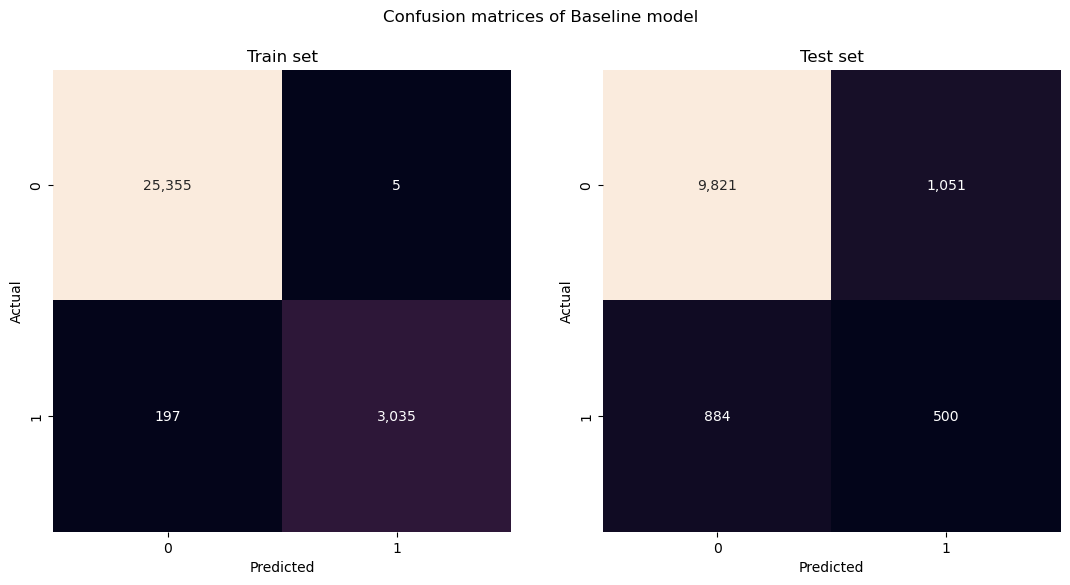

In [91]:
# The confusion matrix

from sklearn.metrics import confusion_matrix
conf_mat = {0: ["Train set", list(confusion_matrix(y_train, baseline_train_pred))], 1: ["Test set", list(confusion_matrix(y_test, baseline_test_pred))]}

fig, axes = plt.subplots(1,2,figsize=(13, 6))
plt.suptitle("Confusion matrices of Baseline model")

for i, ax in enumerate(axes.flat):
    cm = conf_mat[i][1]
    matrix = sns.heatmap(cm, ax=ax, annot=True, fmt=",", cbar=False)
    matrix.set_xlabel("Predicted")
    matrix.set_ylabel("Actual")
    matrix.set_title(conf_mat[i][0])

The baseline model performed significantly worse on the test set (it overfitted on the train set). This can be best seen through the explosion of false positives by the factor of 260 and then followed by 6-fold increase of false negatives.

The overall worsening will be properly captured by the numeric indicators.

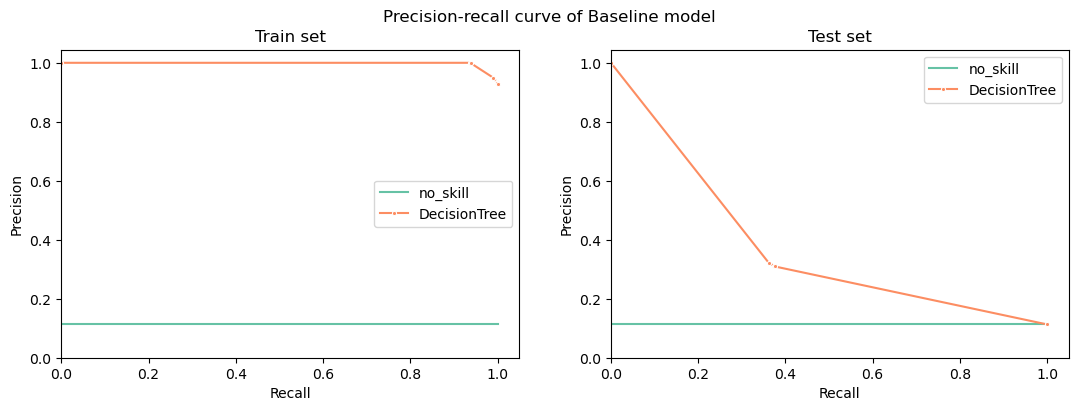

In [92]:
dt_train_prob, dt_test_prob = dt_clf.predict_proba(X_train_transformed)[:,1], dt_clf.predict_proba(X_test_transformed)[:,1]
dt_train_precision, dt_train_recall, _ = precision_recall_curve(y_train, dt_train_prob)
dt_test_precision, dt_test_recall, _ = precision_recall_curve(y_test, dt_test_prob)
base_train_no_skill, base_test_no_skill = len(y_train[y_train==1])/len(y_train), len(y_test[y_test==1])/len(y_test)

fig, axes = plt.subplots(1,2,figsize=(13, 4))
plt.suptitle("Precision-recall curve of Baseline model")

sns.lineplot(x=[0,1], y=[base_train_no_skill, base_train_no_skill], dashes="--", label="no_skill", ax=axes[0])
sns.lineplot(dt_train_recall, dt_train_precision, marker=".", label="DecisionTree", ax=axes[0])
axes[0].legend(loc=0)
axes[0].set_title("Train set")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)

sns.lineplot(x=[0,1], y=[base_test_no_skill, base_test_no_skill], dashes="--", label="no_skill", ax=axes[1])
sns.lineplot(dt_test_recall, dt_test_precision, marker=".", label="DecisionTree", ax=axes[1])
axes[1].legend(loc=0)
axes[1].set_title("Test set")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_xlim(left=0)
axes[1].set_ylim(bottom=0);

Another good visual representation (especially for imbalanced data as it does not take into account true negatives) is the precision-recall curve that is showing the trade-off between precision (TP/(TP+FP)) and recall (TP/(TP+FN)). This could be also helpfull as an threshold indicator for the probability split.

Same as for confusion matrix, it is showing that it is overfit on train data as there we have almost perfect outcome while on the test set it is much worse (although still better than the base estimator). How much worse will be seen in the AUPRC.

In [93]:
# Numerical model estimators

# Train set
baseline_train_report = pd.DataFrame(classification_report(y_train, baseline_train_pred, output_dict=True)).T.round(4)
b_train_f = baseline_train_report.loc["weighted avg", "f1-score"]
baseline_train_aps = average_precision_score(y_train, baseline_train_pred)

print(f"\033[1mBaseline training set\033[0m")
print(f"The \033[1mweighted f1-score\033[0m for the training set is \033[47m{b_train_f}\033[49m")
print(f"The \033[1maverage precision score\033[0m for the training set is \033[47m{baseline_train_aps.round(4)}\033[49m")

print("\n")                                                       
                                                                                  
# Test set
baseline_test_report  = pd.DataFrame(classification_report(y_test, baseline_test_pred, output_dict=True)).T.round(4)
b_test_f = baseline_test_report.loc["weighted avg", "f1-score"]
baseline_test_aps = average_precision_score(y_test, baseline_test_pred)

print(f"\033[1mBaseline test set\033[0m")
print(f"The \033[1mweighted f1-score\033[0m for the training set is \033[47m{b_test_f}\033[49m")
print(f"The \033[1maverage precision score\033[0m for the test set is \033[47m{baseline_test_aps.round(4)}\033[49m")

Baseline training set
The weighted f1-score for the training set is 0.9928
The average precision score for the training set is 0.9444


Baseline test set
The weighted f1-score for the training set is 0.846
The average precision score for the test set is 0.1886


Due to the level of imbalance even the weighted f1-score was not able to fully capture the worsening of the model.

Luckily, average precision score is and shows that out model performed between 5 and 6 times worse on the test set.

## Feature importance

Redundant feature count for solver "liblinear" is : 0
Redundant feature names for solver "liblinear" is : []


Redundant feature count for solver "saga" is : 0
Redundant feature names for solver "saga" is : []




,Solver,cci,cpi,clients_marital_status,clients_education,weekday_of_last_contact,yn_house_loan,clients_age,month_of_last_contact,clients_job,yn_pers_loan,curr_camp_num_calls,prev_camp_num_calls,yn_loan_default,num_of_employees,contact_channel,last_contact,prev_camp_outcome
0,liblinear,0.118478,0.104316,0.085298,0.046230,0.038379,0.033446,0.013499,0.003337,-0.015010,-0.066889,-0.068576,-0.159125,-0.278471,-0.753539,-0.760686,-0.909393,-1.331825
1,saga,0.118462,0.104277,0.085271,0.046193,0.038356,0.033389,0.013414,0.003326,-0.015017,-0.066799,-0.068583,-0.159271,-0.278382,-0.753449,-0.760597,-0.909728,-1.332046


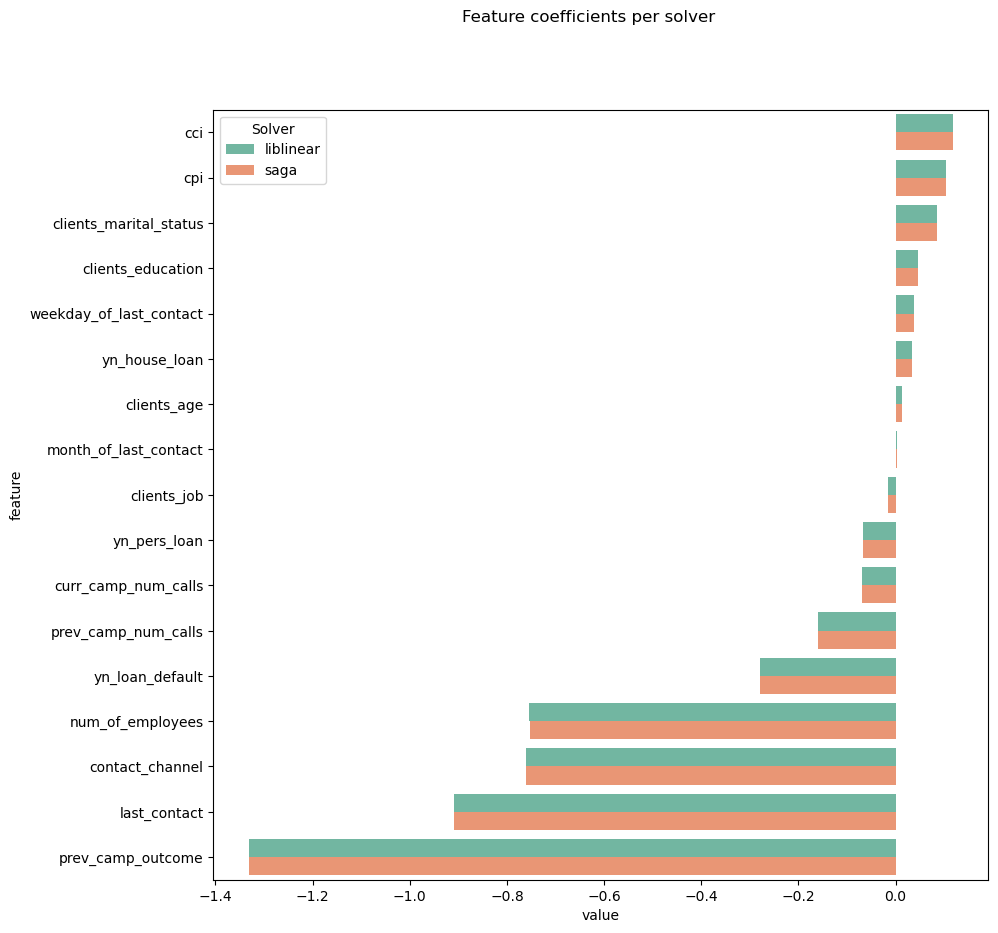

In [94]:
param = {"C": [0.01, 0.1, 1, 10, 100]}
val = pd.DataFrame()

for solver in ["liblinear","saga"]:
    lr = LogisticRegression(solver = solver, penalty = "l1", random_state=seed, max_iter=10000, n_jobs=-1, class_weight = weight)
    gs_model = GridSearchCV(estimator=lr, param_grid=param)
    gs_model.fit(X_train_transformed, y_train)
    fs_logReg = LogisticRegression(**gs_model.best_params_, solver = solver, penalty='l1', random_state=seed, max_iter=10000, n_jobs=-1, class_weight = weight)
    fs_logReg.fit(X_train_transformed, y_train)
    coef = fs_logReg.coef_[0]
    feature_scores = pd.Series(coef, index=col_names).sort_values(ascending=False)
    m = pd.Series(solver, name="Solver")
    v = pd.DataFrame(fs_logReg.coef_, columns=col_names).T.sort_values(by=0, ascending=False).T
    mv = pd.concat([m,v], axis=1)
    val = pd.concat([val, mv], axis=0, ignore_index=True)
    
    print(f"Redundant feature count for solver \"{solver}\" is : {sum(coef==0)}")
    print(f"Redundant feature names for solver \"{solver}\" is : {list(pd.Series(col_names)[list(coef==0)])}")
    print("\n")

graph_columns = {"index": "feature", 0: "value", 1: "value"}

graph = val.drop("Solver", axis=1)
s_l = graph.loc[0,:].T.reset_index()
s_l.insert(1, "Solver", "liblinear")
s_l.rename(columns=graph_columns, inplace=True)

s_s = graph.loc[1,:].T.reset_index()
s_s.insert(1, "Solver", "saga")
s_s.rename(columns=graph_columns, inplace=True)

c = pd.concat([s_l,s_s], axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle ("Feature coefficients per solver", y=0.98)

sns.barplot(data=c, x="value", y="feature", hue="Solver")

val

Neither liblinear nor saga solvers suggest that any feature should be removed. For each feature solvers calculate almost identical parameters.

Features "cci", "cpi", "clinets_martial_status", "clients_education", "weekday_of_last_contact", "yn_house_loan", "clients_age", and "month_of_last_contact" positively influence the probability of instance being classified as positive (placing a deposit). Others do the opposite.

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,12,15,13,0,9,14,11,10,8,1,7,6,5,4,3,2,16
feature,num_of_employees,prev_camp_outcome,month_of_last_contact,clients_job,curr_camp_num_calls,weekday_of_last_contact,cci,cpi,clients_age,clients_education,yn_loan_default,last_contact,contact_channel,yn_pers_loan,yn_house_loan,clients_marital_status,prev_camp_num_calls
feature_importance,0.68067,0.25739,0.040866,0.021075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


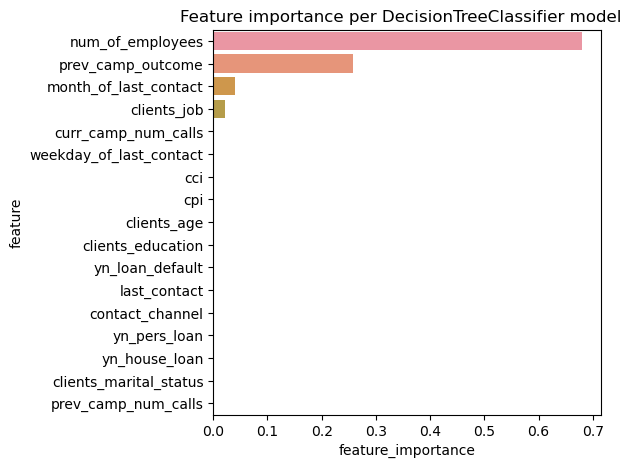

In [95]:
dt_grid = {
              "max_depth": [2,3,4,5],
              "min_samples_split": [2, 5, 10],
              "ccp_alpha": [0.0, 0.0001, 0.001],
              "max_features": ["log2", "sqrt"]
           }

fs_dtc = DecisionTreeClassifier(random_state=seed, class_weight = weight)
fs_dtc_gsCV = GridSearchCV(fs_dtc, dt_grid, cv = 5, n_jobs=-1, verbose=1)
fs_dtc_gsCV.fit(X_train_transformed, y_train)
tuned_fs_dtc = fs_dtc_gsCV.best_estimator_
tuned_fs_dtc.fit(X_train_transformed, y_train)

f_i = pd.DataFrame(zip(col_names,tuned_fs_dtc.feature_importances_), columns=["feature", "feature_importance"])
f_i.sort_values(by="feature_importance", ascending = False, inplace=True)

fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle ("Feature importance per DecisionTreeClassifier model", y=0.92)
sns.barplot(data=f_i, x="feature_importance", y="feature", orient="h");

f_i.T

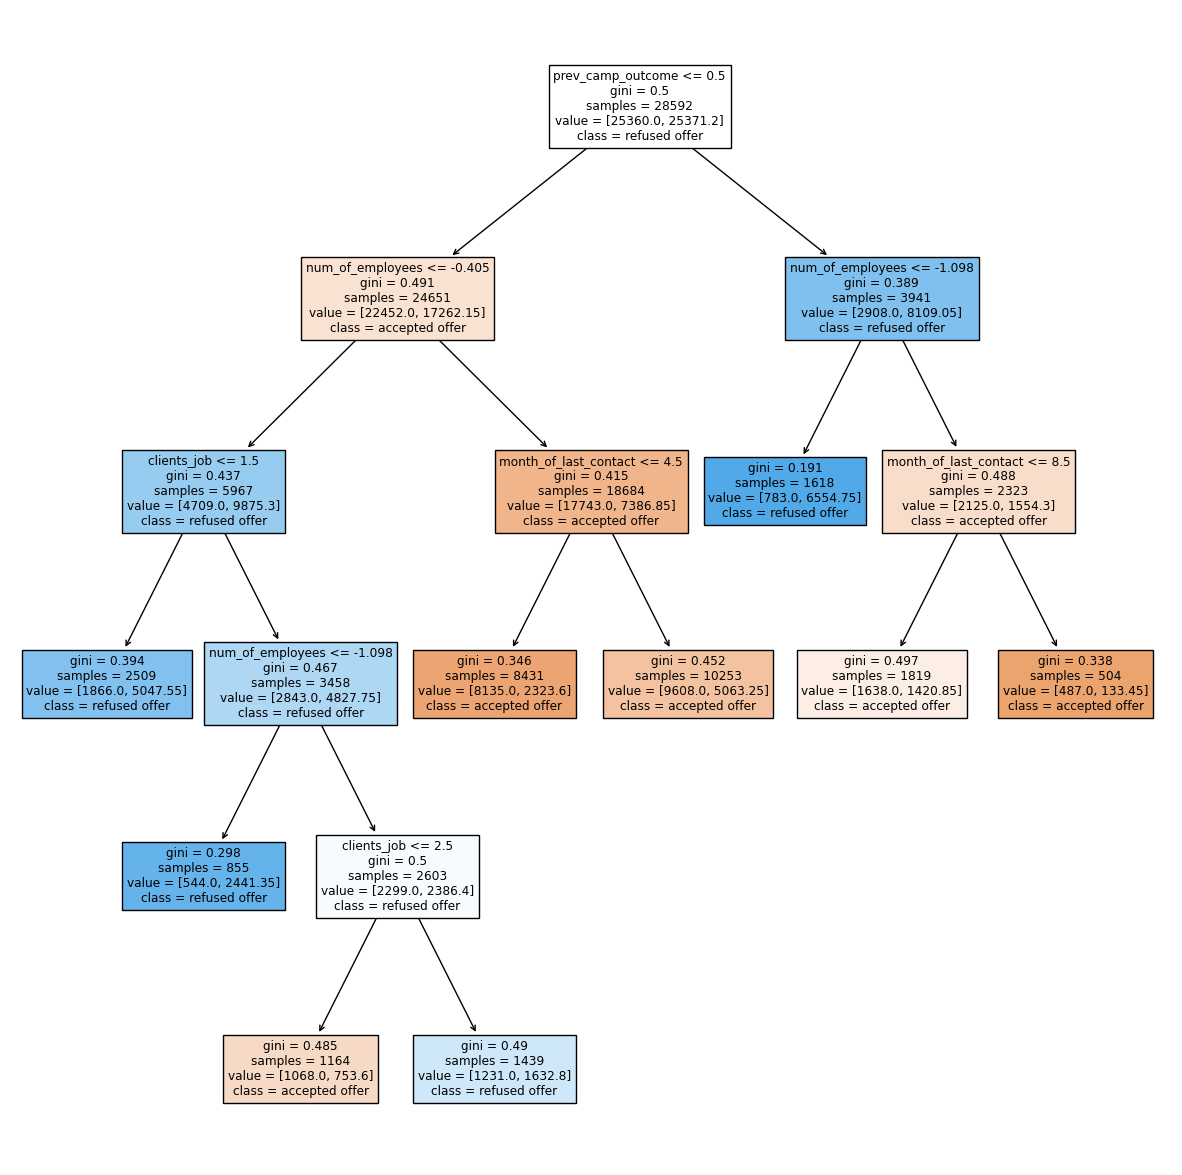

In [96]:
fig = plt.figure(figsize=(15,15))
_ = plot_tree(tuned_fs_dtc,filled=True, feature_names = col_names, class_names=["accepted offer", "refused offer"])

The created decision tree indicates that 6 features can be kept as relevant and only 3 with real importance - "euribor3m", "cci", "num_of_employees", and "month of last contact".

Given the data imbalance it would be best not to remove any feature before moving to the main model - RandomForestClassifier.

## The main model - RandomForestClassifier

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


,12,11,6,10,13,5,8,16,15,1,14,9,0,7,2,3,4
feature,num_of_employees,cci,last_contact,cpi,month_of_last_contact,contact_channel,clients_age,prev_camp_num_calls,prev_camp_outcome,clients_education,weekday_of_last_contact,curr_camp_num_calls,clients_job,yn_loan_default,clients_marital_status,yn_house_loan,yn_pers_loan
feature_importance,0.353458,0.146299,0.103175,0.098232,0.057218,0.048978,0.042372,0.034225,0.024743,0.018814,0.018751,0.016608,0.013433,0.008571,0.007401,0.003891,0.003831


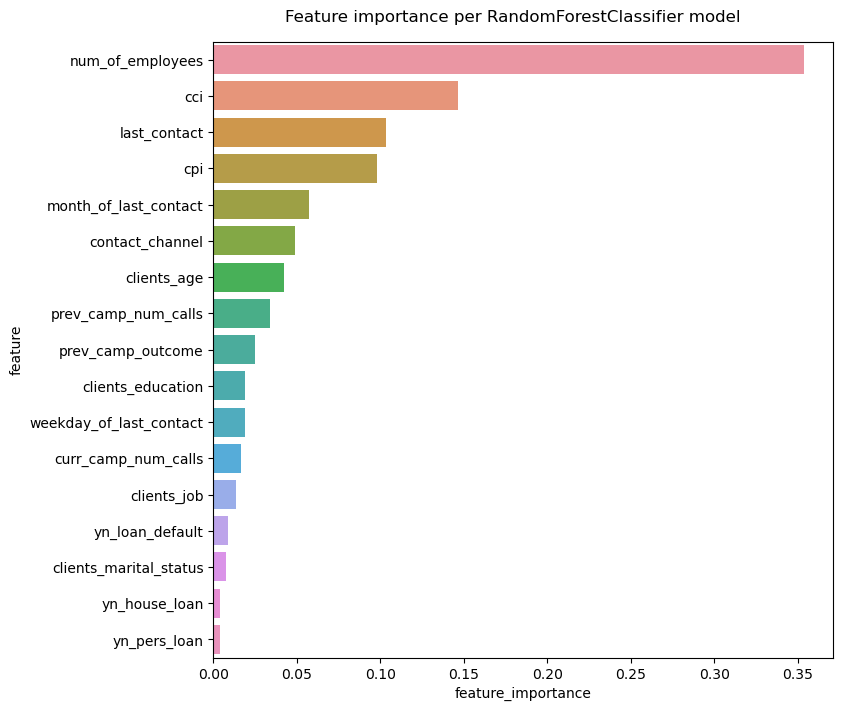

In [97]:
rf_grid = {
              "max_depth": [5,6,7,8],
              "min_samples_split": [2, 5, 10],
              "n_estimators": [100, 150, 200],
              "max_features": ["log2", "sqrt", None],
              "max_samples": [None, 0.7, 0.9]
           }

rfc = RandomForestClassifier(random_state=seed, class_weight = weight)
rfc_gsCV = GridSearchCV(rfc, rf_grid, cv = 5, n_jobs=-1, verbose=1, scoring = "average_precision")
rfc_gsCV.fit(X_train_transformed, y_train)
tuned_rfc = rfc_gsCV.best_estimator_
tuned_rfc.fit(X_train_transformed, y_train)

f_i = pd.DataFrame(zip(col_names,tuned_rfc.feature_importances_), columns=["feature", "feature_importance"])
f_i.sort_values(by="feature_importance", ascending = False, inplace=True)

fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle ("Feature importance per RandomForestClassifier model", y=0.92)
sns.barplot(data=f_i, x="feature_importance", y="feature", orient="h");

f_i.T

In [98]:
# What are the best model parameters that were chose by GridSearch
rfc_gsCV.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 7.85}, max_depth=8,
                       max_features='log2', min_samples_split=10,
                       n_estimators=200, random_state=13)

In [99]:
# Predict on the whole training set
rf_train_pred = tuned_rfc.predict(X_train_transformed)
rf_test_pred  = tuned_rfc.predict(X_test_transformed)

### Evaluating predictions of the whole training set

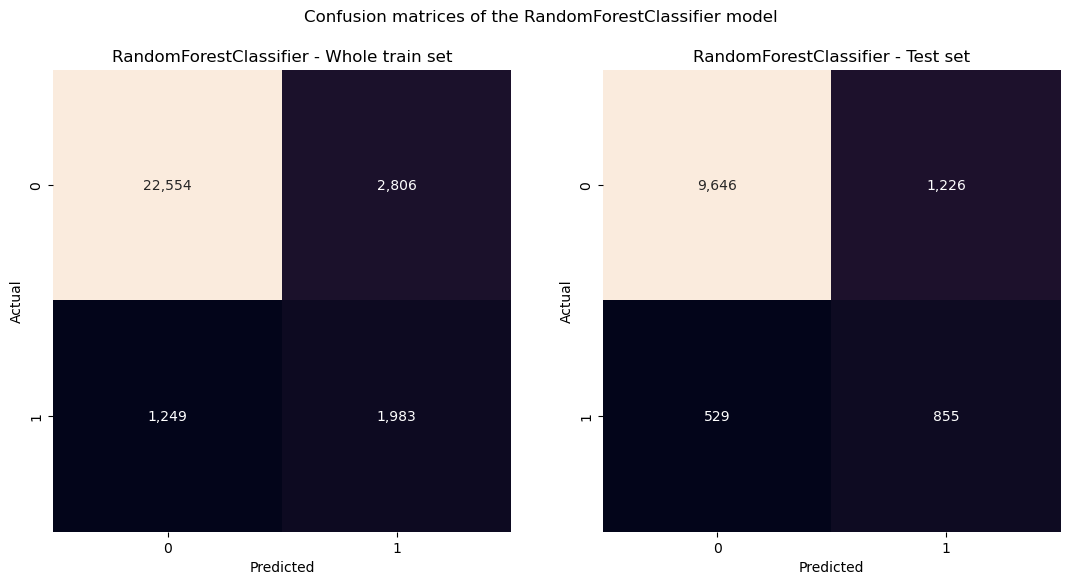

In [100]:
# The confusion matrix
conf_mat = {0: ["RandomForestClassifier - Whole train set", list(confusion_matrix(y_train, rf_train_pred))], 1: ["RandomForestClassifier - Test set", list(confusion_matrix(y_test, rf_test_pred))]}

fig, axes = plt.subplots(1,2,figsize=(13, 6))
plt.suptitle("Confusion matrices of the RandomForestClassifier model")

for i, ax in enumerate(axes.flat):
    cm = conf_mat[i][1]
    matrix = sns.heatmap(cm, ax=ax, annot=True, fmt=",", cbar=False)
    matrix.set_xlabel("Predicted")
    matrix.set_ylabel("Actual")
    matrix.set_title(conf_mat[i][0])

Unlike with the baseline model the random forest definitely did not overfit.

For the training set, false positives were calculated with rate of 11% of total negative values, while rate of false negatives is 39%.

For the test set, false positives were calculated with rate of 11% of total negative values, while rate of false negatives is 38%.

The results with the test set are almost identical to the ones on the train set.

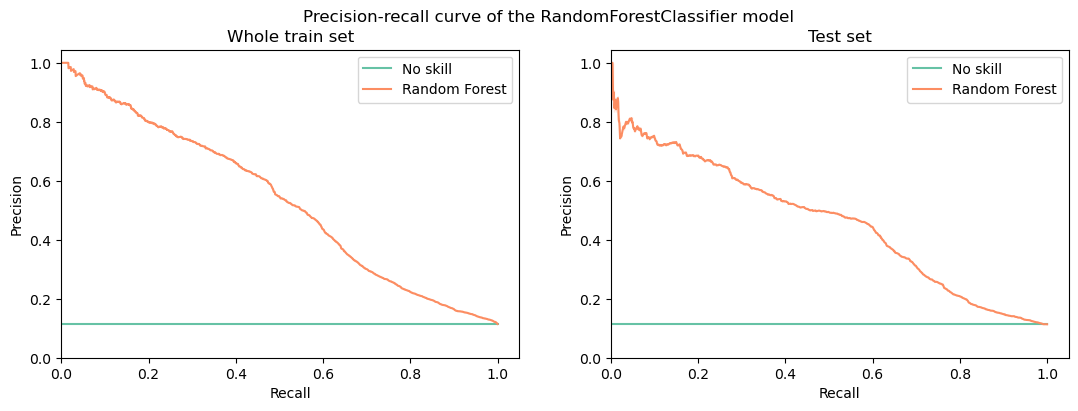

In [101]:
# Recall-precision curve for Random Forest
rf_train_prob, rf_test_prob = tuned_rfc.predict_proba(X_train_transformed)[:,1], tuned_rfc.predict_proba(X_test_transformed)[:,1]
rf_train_precision, rf_train_recall, _ = precision_recall_curve(y_train, rf_train_prob)
rf_test_precision, rf_test_recall, _ = precision_recall_curve(y_test, rf_test_prob)
rf_train_no_skill, rf_test_no_skill = len(y_train[y_train==1])/len(y_train), len(y_test[y_test==1])/len(y_test)

fig, axes = plt.subplots(1,2,figsize=(13, 4))
plt.suptitle("Precision-recall curve of the RandomForestClassifier model")

sns.lineplot(x=[0,1], y=[rf_train_no_skill, rf_train_no_skill], dashes="--", label="No skill", ax=axes[0])
sns.lineplot(rf_train_recall, rf_train_precision, label="Random Forest", ax=axes[0])
axes[0].legend(loc=0)
axes[0].set_title("Whole train set")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)

sns.lineplot(x=[0,1], y=[rf_test_no_skill, rf_test_no_skill], dashes="--", label="No skill", ax=axes[1])
sns.lineplot(rf_test_recall, rf_test_precision, label="Random Forest", ax=axes[1])
axes[1].legend(loc=0)
axes[1].set_title("Test set")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_xlim(left=0)
axes[1].set_ylim(bottom=0);

In [102]:
# Numerical model estimators

# Train set
rf_train_report = pd.DataFrame(classification_report(y_train, rf_train_pred, output_dict=True)).T.round(4)
rf_train_f = rf_train_report.loc["weighted avg", "f1-score"]
rf_train_aps = average_precision_score(y_train, rf_train_pred)

print(f"\033[1mRandom Forest training set\033[0m")
print(f"The \033[1mweighted f1-score\033[0m for the training set is \033[47m{b_train_f}\033[49m")
print(f"The \033[1maverage precision score\033[0m for the training set is \033[47m{rf_train_aps.round(4)}\033[49m")

print("\n")                                                       
                                                                                  
# Test set
rf_test_report  = pd.DataFrame(classification_report(y_test, rf_test_pred, output_dict=True)).T.round(4)
rf_test_f = rf_test_report.loc["weighted avg", "f1-score"]
rf_test_aps = average_precision_score(y_test, rf_test_pred)

print(f"\033[1mRandomForest test set\033[0m")
print(f"The \033[1mweighted f1-score\033[0m for the test set is \033[47m{b_test_f}\033[49m")
print(f"The \033[1maverage precision score\033[0m for the test set is \033[47m{rf_test_aps.round(4)}\033[49m")

Random Forest training set
The weighted f1-score for the training set is 0.9928
The average precision score for the training set is 0.2977


RandomForest test set
The weighted f1-score for the test set is 0.846
The average precision score for the test set is 0.297


Given the small difference between average precision score on train and test data it can be said that the model did not overfit on the training data.

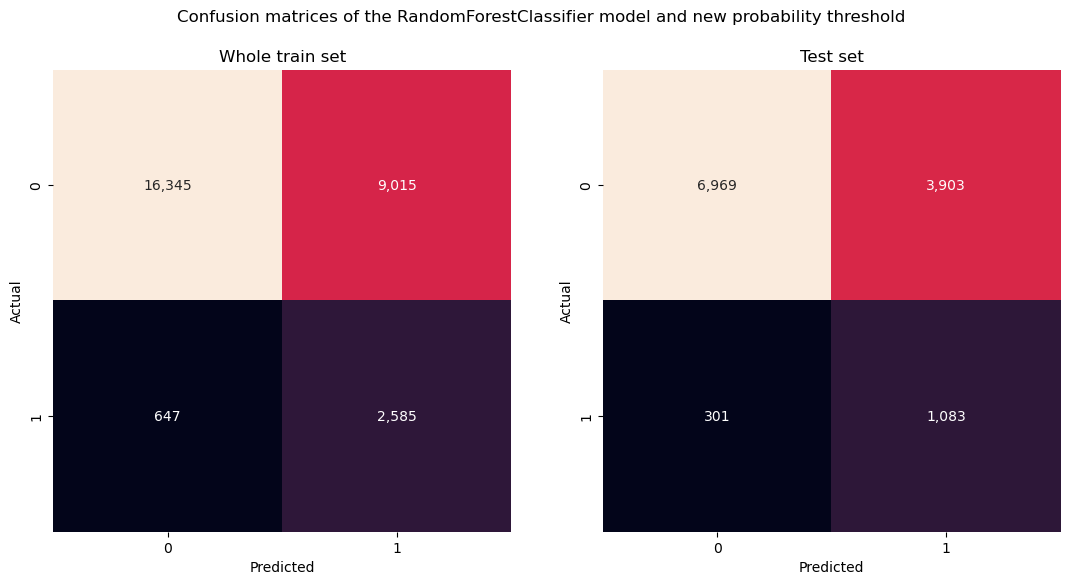

In [103]:
new_threshold = 0.35

rf_train_predictions_new_threshold = np.multiply(rf_train_prob >= new_threshold, 1)
rf_test_predictions_new_threshold  = np.multiply(rf_test_prob  >= new_threshold, 1)

rf_train_new_threshold_cm = confusion_matrix(y_train, rf_train_predictions_new_threshold)
rf_test_new_threshold_cm = confusion_matrix(y_test, rf_test_predictions_new_threshold)

fig, axes = plt.subplots(1,2,figsize=(13, 6))
plt.suptitle("Confusion matrices of the RandomForestClassifier model and new probability threshold")
conf_mat = {0: ["Whole train set", list(rf_train_new_threshold_cm)], 1: ["Test set", list(rf_test_new_threshold_cm)]}

for i, ax in enumerate(axes.flat):
    cm = conf_mat[i][1]
    matrix = sns.heatmap(cm, ax=ax, annot=True, fmt=",", cbar=False)
    matrix.set_xlabel("Predicted")
    matrix.set_ylabel("Actual")
    matrix.set_title(conf_mat[i][0])

If a new probability threshold of 0.35 (instead of 0.5) is applied the number of false negatives drops from 1778 to 948 (in rate term from 38.5% to 20.5%)

## Final thoughts

The good news is that the model did not overfit on the train data.
The not so good news is that it unfortunately did not provide exceptional results as the calculated average precision on the test data is 0.297 (values are in range 0 to 1, with higher means better).

However, if we lower the prbability threshold to 0.35 on the whole set we would identify 80% of positive outcomes but with around 40% of calls that were made during this campaign. The rest of the calls will just lead to success rate imporovement (and getting new data points for the future models).

Other insights (from data exploratory analysis:

- In absolute terms the campaign was most successful with clients that work in administration. However, in relative terms best are retired (but having in mind previous ethical concern) and students.
- In absolute terms the campaign was most successful with clients that are married. However, in relative terms it was most successful with single clients.
- September through March seems to be the best period for the campaign given the relative success rate
- During the second half of the work-week people seem to be a bit more open to the campaign offer
- Previously contacted people are familiar with the campaign and are more open for it.